## Import necessary packages

In [1]:
import numpy as np
import scipy.io
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import nibabel as nib
import os

import datetime
import time
import sys
import warnings
import glob

import seaborn as sns
from sklearn.metrics import pairwise_distances

code_folder = os.getcwd()
path_to_functions = os.path.join(code_folder, '..')
sys.path.insert(0, path_to_functions)
import functions as funcs
import importlib
importlib.reload(funcs)

from matplotlib.ticker import PercentFormatter
# import netplotbrain
from nilearn import plotting
import matplotlib.cm as cm
import matplotlib.colors as colors
import nilearn
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Global variables

In [3]:
num_parcels = 116
num_cortical_parcels = 100

tau_min = 0
tau_max = 3

pc_alpha = 1
alpha_level = 1e-2/32     # 32 comes from correction for multiple comparisons accross lags (number of lags including lag 0 = 4)

num_subjects_ready = 200
num_networks = 16

network_dic = "{'LH_Vis':[],'LH_Som':[],'LH_Dor':[],'LH_Sal':[], 'LH_Lim':[], 'LH_Con':[], 'LH_Def':[], 'LH_Sub' :[], 'RH_Vis':[],'RH_Som':[],'RH_Dor':[],'RH_Sal':[], 'RH_Lim':[], 'RH_Con':[],'RH_Def':[], 'RH_Sub':[]}"
net_labels = ['LH_Vis','LH_Som','LH_Dor','LH_Sal', 'LH_Lim','LH_Con','LH_Def','LH_Sub', 'RH_Vis','RH_Som','RH_Dor','RH_Sal', 'RH_Lim', 'RH_Con', 'RH_Def', 'RH_Sub']

net_labels_visualization = ['L-Vis','L-Som-Mot','L-Dors-Att','L-Vent-Att', 'L-Lim','L-Cont','L-Def','L-Sub', 'R-Vis','R-Som-Mot','R-Dors-Att','R-Vent-Att', 'R-Lim', 'R-Cont', 'R-Def', 'R-Sub']
visualization_labels = ['L-Vis','L-Som-Mot','L-Dors-Att','L-Vent-Att','L-Lim','L-Cont','L-Def','R-Vis','R-Som-Mot','R-Dors-Att','R-Vent-Att','R-Lim','R-Cont','R-Def','R-Sub','L-Sub']


## Set the Path to External Packages and Files, Results, and Data

In [4]:
code_folder = os.getcwd()
files_folder = os.path.join(code_folder, '..', 'External Packages and Files')
results_folder = os.path.join(code_folder, '..', 'Results')
data_folder = os.path.join(code_folder, '..', 'Data')

# Read cortical and subcortical parcel labels

In [5]:
#Read cortical and subcortical parcel labels
df_cortical = pd.read_csv(os.path.join(files_folder, 'Schaefer2018_100Parcels_7Networks_order.txt'), delimiter = '\t', header=None)
df_subcortical = pd.read_csv(os.path.join(files_folder, 'Tian_Subcortex_S1_3T_label.txt'), delimiter = '\t', header=None)

Schaefer2018_100Parcels_7Networks_labels = df_cortical[1]
Tian_Subcortex_S1_3T_labels = list(df_subcortical[0])

parcel_labels = []
parcel_labels_short = []

for i in range(0,num_parcels):
    if i < num_cortical_parcels:
        parcel_labels.append(Schaefer2018_100Parcels_7Networks_labels[i][10:])

    else:
        parcel_labels.append(Tian_Subcortex_S1_3T_labels[i-num_cortical_parcels])

    parcel_labels_short.append(parcel_labels[i][0:6])

# Standard Colors for Yeo2011, 7 Networks

In [6]:
dataframe = pd.read_csv(os.path.join(files_folder, 'Yeo2011_7Networks_ColorLUT.txt'), delimiter='\t')
Yeo2011_7Networks_ColorLUT = np.array([[120,  18, 134], [70, 130, 180],[0, 118,  14],[196,  58, 250], [220, 248, 164],[230, 148,  34], [205,  62,  78]])

In [7]:
Yeo2011_7Networks_ColorLUT

array([[120,  18, 134],
       [ 70, 130, 180],
       [  0, 118,  14],
       [196,  58, 250],
       [220, 248, 164],
       [230, 148,  34],
       [205,  62,  78]])

# Parcel Indices in Each Subnetwork

In [8]:
num_networks = len(net_labels)
num_parcels = len(parcel_labels)

network_parcel_idx= eval(network_dic)

for i in range (0 , num_parcels):

    if i < num_cortical_parcels:
        temp = parcel_labels[i]
        temp_first = temp[0:6]

        if temp_first in network_parcel_idx:
            network_parcel_idx[temp_first].append(i)
    elif i >= num_cortical_parcels  and i<num_cortical_parcels +8:
        network_parcel_idx['RH_Sub'].append(i)
    
    else:
        network_parcel_idx['LH_Sub'].append(i)
network_parcel_idx

{'LH_Vis': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'LH_Som': [9, 10, 11, 12, 13, 14],
 'LH_Dor': [15, 16, 17, 18, 19, 20, 21, 22],
 'LH_Sal': [23, 24, 25, 26, 27, 28, 29],
 'LH_Lim': [30, 31, 32],
 'LH_Con': [33, 34, 35, 36],
 'LH_Def': [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 'LH_Sub': [108, 109, 110, 111, 112, 113, 114, 115],
 'RH_Vis': [50, 51, 52, 53, 54, 55, 56, 57],
 'RH_Som': [58, 59, 60, 61, 62, 63, 64, 65],
 'RH_Dor': [66, 67, 68, 69, 70, 71, 72],
 'RH_Sal': [73, 74, 75, 76, 77],
 'RH_Lim': [78, 79],
 'RH_Con': [80, 81, 82, 83, 84, 85, 86, 87, 88],
 'RH_Def': [89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
 'RH_Sub': [100, 101, 102, 103, 104, 105, 106, 107]}

# Cortical and subcortical parcel coordinates

In [9]:
# cortical
cortical_parcel_locs_dataframe = pd.read_csv(os.path.join(files_folder, 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'))

cortical_parcel_locs_R = np.reshape(np.array(cortical_parcel_locs_dataframe['R']), (num_cortical_parcels,1))
cortical_parcel_locs_A = np.reshape(np.array(cortical_parcel_locs_dataframe['A']),(num_cortical_parcels,1))
cortical_parcel_locs_S = np.reshape(np.array(cortical_parcel_locs_dataframe['S']), (num_cortical_parcels,1))
cortical_parcel_locs = np.concatenate((cortical_parcel_locs_R, cortical_parcel_locs_A, cortical_parcel_locs_S), axis = 1)

# subcortical
subcortical_parcel_locs_dataframe = pd.read_csv(os.path.join(files_folder,'Tian_Subcortex_S1_3T_COG.txt'), delimiter = '\t', header =  None)
subcortical_parcel_locs = np.array(subcortical_parcel_locs_dataframe)

parcel_locs = np.concatenate((cortical_parcel_locs, subcortical_parcel_locs), axis = 0)

# HCP resting-state fMRI data

### Select subjects

In [10]:
subjs = scipy.io.loadmat(os.path.join(data_folder,'HCP/subjs.mat'))['subjs']

num_subjects = len(subjs)
selected_subjects_name = []

for s in range(0, num_subjects):
    
    temp_subj = scipy.io.loadmat(os.path.join(data_folder,'HCP/subjs.mat'))['subjs'][s][0]
    selected_subjects_name.append(temp_subj) 

print('Total number of subjects:', num_subjects)

Total number of subjects: 700


## Load behavioral data

In [11]:
behavioral_df = pd.read_csv(os.path.join(files_folder,'HCP_behavioral_data.csv'))

behavioral_subjects_name_list = list(behavioral_df['Subject'])
behavioral_subjects_age_list = list(behavioral_df['Age'])
behavioral_subjects_gender_list = list(behavioral_df['Gender'])

## Load preprocessed fMRI data

In [12]:
fmri_data_rest_1_RL = []
fmri_data_rest_2_RL = []

fmri_data_rest_1_LR = []
fmri_data_rest_2_LR = []

behavioral_selected_subjects_age = []
behavioral_selected_subjects_gender = []

for file in os.listdir(os.path.join(data_folder,'HCP')):
    if file.endswith(".npy"):
        path_to_data = os.path.join(os.path.join(data_folder,'HCP'), file)

        file_name_split = file[:-4].split('_')

        R_L = file_name_split[-1]
        Rest_1_2 = file_name_split[-2]
        subj_name = file_name_split[-3]

        if subj_name in selected_subjects_name:

            if (R_L == 'RL' and Rest_1_2 == 'REST1'):
                fmri_data_rest_1_RL.append(np.load(path_to_data).T)

                behavioral_subjects_idx = behavioral_subjects_name_list.index(int(subj_name))
                behavioral_selected_subjects_age.append(behavioral_subjects_age_list[behavioral_subjects_idx])
                behavioral_selected_subjects_gender.append(behavioral_subjects_gender_list[behavioral_subjects_idx])

            elif (R_L == 'RL' and Rest_1_2 == 'REST2'):
                fmri_data_rest_2_RL.append(np.load(path_to_data).T)
                
            elif (R_L == 'LR' and Rest_1_2 == 'REST1'):
                fmri_data_rest_1_LR.append(np.load(path_to_data).T)

            elif (R_L == 'LR' and Rest_1_2 == 'REST2'):
                fmri_data_rest_2_LR.append(np.load(path_to_data).T)
            
print('Number of RL, Rest 1:', len(fmri_data_rest_1_RL) )
print('Number of RL, Rest 2:', len(fmri_data_rest_2_RL) )
print('Number of LR, Rest 1:', len(fmri_data_rest_1_LR) )
print('Number of LR, Rest 2:', len(fmri_data_rest_2_LR) )

Number of RL, Rest 1: 700
Number of RL, Rest 2: 700
Number of LR, Rest 1: 700
Number of LR, Rest 2: 700


## Save/Load data

In [13]:
# np.savez(os.path.join(results_folder,'HCP_Rest_700_Subjects'),fmri_data_rest_1_RL = fmri_data_rest_1_RL, fmri_data_rest_2_RL = fmri_data_rest_2_RL, fmri_data_rest_1_LR = fmri_data_rest_1_LR,fmri_data_rest_2_LR = fmri_data_rest_2_LR, selected_subjects_name = selected_subjects_name )
funcs.import_npz(os.path.join(results_folder,'HCP_Rest_700_Subjects.npz'))

# Causality Analysis

##  CaLLTiF Results on HCP Resting-State fMRI

### Load results

In [14]:
def import_npz(npz_file):
    Data = np.load(npz_file, allow_pickle= True)
    for varName in Data:
        globals()[varName] = Data[varName]  

In [15]:
import_npz(os.path.join(results_folder,'multipledataset_calltif_hcp_rest.npz'))
import_npz(os.path.join(results_folder,'multipledataset_calltif_hcp_rest_tau_max_1.npz'))

In [16]:
# np.savez(os.path.join(results_folder,'multipledataset_calltif_hcp_rest'),multipledataset_calltif_hcp_rest_link_matrix = multipledataset_pcmci_hcp_rest_link_matrix, multipledataset_calltif_hcp_rest_execution_time = multipledataset_pcmci_hcp_rest_execution_time)


In [17]:
time_series_graph_hcp_rest_all_subjects = []
time_series_graph_hcp_rest_all_subjects_pvalues = []

hcp_rest_all_graphs = []
hcp_rest_all_graphs_p_values = []

for s in range(0, num_subjects_ready):

    final_graph_org = multipledataset_calltif_hcp_rest_link_matrix[s]['graph']
    p_matrix = np.array(multipledataset_calltif_hcp_rest_link_matrix[s]['p_matrix'])
    
    # Threshold p_matrix to get graph
    final_graph_new = p_matrix <= alpha_level
    
    # Convert to string graph representation
    graph = funcs.convert_to_string_graph(final_graph_new)

    # Time series graph
    time_series_graph_hcp_rest_all_subjects.append(graph)
    time_series_graph_hcp_rest_all_subjects_pvalues.append(p_matrix)

    # combined graph across lags
    summary_graph, binary_matrix , binary_matrix_p_value= funcs.summarize_across_all_lags_v2_with_pvalues(graph, p_matrix)
    
    hcp_rest_all_graphs.append(binary_matrix)
    hcp_rest_all_graphs_p_values.append(binary_matrix_p_value)

#### Compare the causal graphs computed with tau_max = 3 and tau_max = 1

In [18]:
num_subjects_for_comparison = 30

In [19]:
time_series_graph_hcp_rest_all_subjects_tau_max_1 = []
time_series_graph_hcp_rest_all_subjects_pvalues_tau_max_1 = []

hcp_rest_all_graphs_tau_max_1 = []
hcp_rest_all_graphs_p_values_tau_max_1 = []

for s in range(0, num_subjects_for_comparison):

    final_graph_org_tau_max_1 = multipledataset_calltif_hcp_rest_link_matrix_tau_max_1[s]['graph']
    p_matrix_tau_max_1 = np.array(multipledataset_calltif_hcp_rest_link_matrix_tau_max_1[s]['p_matrix'])
    
    # Threshold p_matrix to get graph
    final_graph_new_tau_max_1 = p_matrix_tau_max_1 <= alpha_level
    
    # Convert to string graph representation
    graph_tau_max_1 = funcs.convert_to_string_graph(final_graph_new_tau_max_1)

    # Time series graph
    time_series_graph_hcp_rest_all_subjects_tau_max_1.append(graph_tau_max_1)
    time_series_graph_hcp_rest_all_subjects_pvalues_tau_max_1.append(p_matrix_tau_max_1)

    # combined graph across lags
    summary_graph_tau_max_1, binary_matrix_tau_max_1 , binary_matrix_p_value_tau_max_1= funcs.summarize_across_all_lags_v2_with_pvalues(graph_tau_max_1, p_matrix_tau_max_1)
    
    hcp_rest_all_graphs_tau_max_1.append(binary_matrix_tau_max_1)
    hcp_rest_all_graphs_p_values_tau_max_1.append(binary_matrix_p_value_tau_max_1)

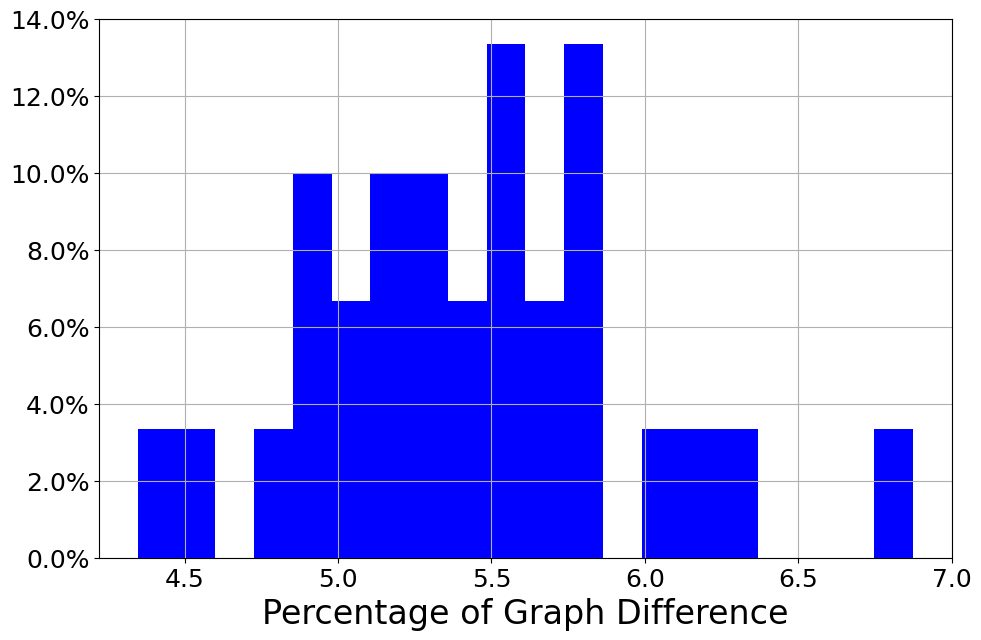

In [20]:
abs_diff = np.zeros((num_subjects_for_comparison,1))
for s in range(0, num_subjects_for_comparison):
    abs_diff[s] = 100*np.sum(np.abs(hcp_rest_all_graphs[s] - hcp_rest_all_graphs_tau_max_1[s]))/(num_parcels*num_parcels)

plt.figure(figsize = (11,7))
p = plt.hist(abs_diff, 20, weights=np.ones(len(abs_diff)) / len(abs_diff), color = 'blue')
plt.grid()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Percentage of Graph Difference', fontsize = 24)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)

### Distribution of Causal Graph Density 

Mean CaLLTiF Graph Density: 0.4118634809750297


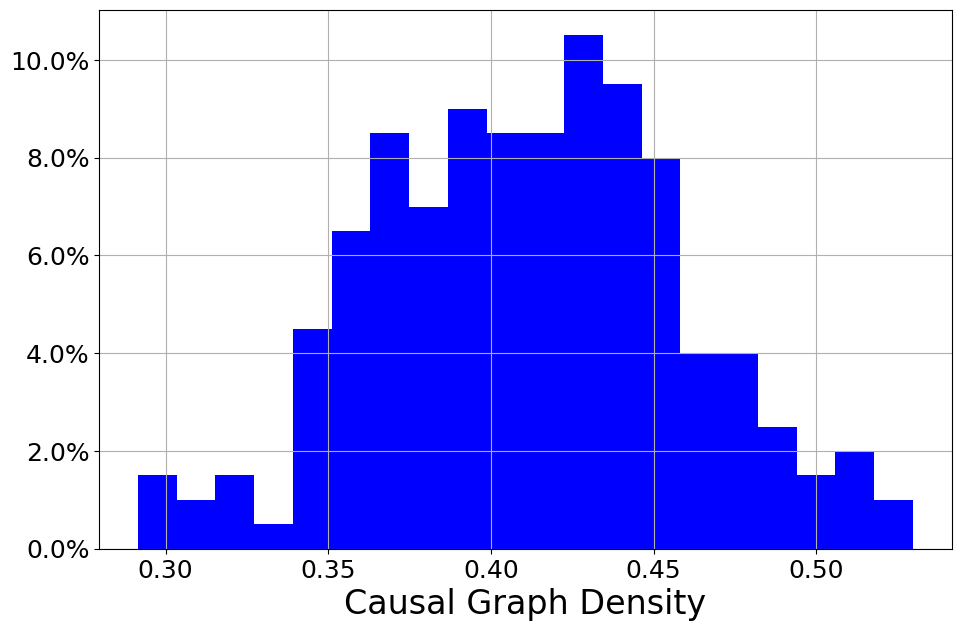

In [21]:
CaLLTiF_Graph_density = []
for s in range(0,num_subjects_ready):
    CaLLTiF_Graph_density.append(np.mean(np.array(hcp_rest_all_graphs[s][:,:])))

plt.figure(figsize = (11,7))
plt.hist(CaLLTiF_Graph_density, 20, weights=np.ones(len(CaLLTiF_Graph_density)) / len(CaLLTiF_Graph_density), color = 'blue')
plt.grid()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Causal Graph Density', fontsize = 24)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)

print('Mean CaLLTiF Graph Density:', np.mean(CaLLTiF_Graph_density))    

### Parcel-Level Graph Parameters

In [22]:
degree_centrality_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
betweenness_centrality_all_parcels_individual_sub =  np.zeros((num_parcels,num_subjects_ready))
load_centrality_all_parcels_individual_sub =  np.zeros((num_parcels,num_subjects_ready))
eigenvector_centrality_all_parcels_individual_sub =  np.zeros((num_parcels,num_subjects_ready))

out_degree_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
in_degree_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
degree_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
causal_flow_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))
hubness_all_parcels_individual_sub = np.zeros((num_parcels,num_subjects_ready))

all_networks_num_edges_from_to_individual_sub = np.zeros((num_networks, num_networks, num_subjects_ready))

for s in range(num_subjects_ready):

    graph = hcp_rest_all_graphs[s]
    G = nx.DiGraph(graph)

    degree_centrality_all_parcels = list(nx.degree_centrality(G).values())
    betweenness_centrality_all_parcels = list(nx.betweenness_centrality(G).values())
    load_centrality_all_parcels = list(nx.load_centrality(G).values())
    eigenvector_centrality_all_parcels = list(nx.eigenvector_centrality(G).values())

    degree_centrality_all_parcels_individual_sub[:,s] = degree_centrality_all_parcels
    betweenness_centrality_all_parcels_individual_sub[:,s] = betweenness_centrality_all_parcels
    load_centrality_all_parcels_individual_sub[:,s] = load_centrality_all_parcels
    eigenvector_centrality_all_parcels_individual_sub[:,s] = eigenvector_centrality_all_parcels

    out_degree_all_parcels = np.mean(graph, axis = 1)
    in_degree_all_parcels = np.mean(graph, axis = 0)
    degree_all_parcels = out_degree_all_parcels + in_degree_all_parcels

    out_degree_all_parcels_individual_sub[:,s] = out_degree_all_parcels
    in_degree_all_parcels_individual_sub[:,s] = in_degree_all_parcels
    degree_all_parcels_individual_sub[:,s] = degree_all_parcels

    causal_flow_all_parcels_individual_sub[:,s] = out_degree_all_parcels - in_degree_all_parcels
    hubness_all_parcels_individual_sub[:,s] = betweenness_centrality_all_parcels/degree_all_parcels

    # look at the networks
    all_networks_num_edges_from_to = funcs.network_map(graph,net_labels, network_dic, parcel_labels, num_cortical_parcels)
    all_networks_num_edges_from_to_individual_sub[:,:,s] = all_networks_num_edges_from_to

/tmp/ipykernel_3707723/76499862.py:38: RuntimeWarning: invalid value encountered in true_divide
  hubness_all_parcels_individual_sub[:,s] = betweenness_centrality_all_parcels/degree_all_parcels


#### Statistical differences between nodal degrees of each pair of parcels 

In [23]:
statistical_differences_in_nodal_degree_between_each_pair_of_parcels = []
k = 0
for n in range(0,num_parcels):
    for m in range(0, num_parcels):
        if m != n:

            pvalue_temp = scipy.stats.wilcoxon(degree_all_parcels_individual_sub[n,:], degree_all_parcels_individual_sub[m,:], alternative='two-sided', zero_method = 'wilcox').pvalue
            effect_size = (np.mean(degree_all_parcels_individual_sub[n,:]) - np.mean(degree_all_parcels_individual_sub[m,:])) / (np.sqrt((np.std(degree_all_parcels_individual_sub[n,:]) ** 2 + np.std(degree_all_parcels_individual_sub[m,:]) ** 2) / 2))
            statistical_differences_in_nodal_degree_between_each_pair_of_parcels.append(pvalue_temp)
            print(effect_size,effect_size)
            # if pvalue_temp< 0.001 and effect_size>



print(np.min(np.array(statistical_differences_in_nodal_degree_between_each_pair_of_parcels)), np.max(np.array(statistical_differences_in_nodal_degree_between_each_pair_of_parcels)))

total_num_pairs = num_parcels*num_parcels-num_parcels
percentage_of_pairs_with_significant_difference_in_nodal_degree = 100*np.shape(np.where(np.array(statistical_differences_in_nodal_degree_between_each_pair_of_parcels) < 0.001)[0])[0]/total_num_pairs
print('Percentage of pairs with p-value < 0.001:', percentage_of_pairs_with_significant_difference_in_nodal_degree)


-0.841940017669095 -0.841940017669095
0.20212996190467364 0.20212996190467364
-1.4690124396930166 -1.4690124396930166
0.32229094694295785 0.32229094694295785
0.19866272972424198 0.19866272972424198
-0.626917404893567 -0.626917404893567
-1.4684899870642047 -1.4684899870642047
-1.1052384589451316 -1.1052384589451316
0.3832398312858071 0.3832398312858071
1.8260842602026168 1.8260842602026168
-1.0502063836987205 -1.0502063836987205
-0.6453952477859541 -0.6453952477859541
0.08923004269918262 0.08923004269918262
-0.13021475342480324 -0.13021475342480324
-1.4001865140817031 -1.4001865140817031
-0.14387113911467833 -0.14387113911467833
0.9600664068303775 0.9600664068303775
0.45466114954274983 0.45466114954274983
0.12582812997538334 0.12582812997538334
-0.5121789215289742 -0.5121789215289742
2.125020157562738 2.125020157562738
-0.2351221661190771 -0.2351221661190771
1.8275004884058896 1.8275004884058896
0.37616900146713766 0.37616900146713766
-0.12451246703751566 -0.12451246703751566
0.51899307

In [24]:
aa = scipy.stats.pearsonr(degree_all_parcels_individual_sub[:,0], degree_all_parcels_individual_sub[:,10])
aa.confidence_interval(confidence_level = 0.95).low


0.8752417527842589

#### Correlations between nodal degrees of each pair of subjects

In [25]:
correlations_in_nodal_degree_between_each_pair_of_subjects = []
correlations_pvalue_in_nodal_degree_between_each_pair_of_subjects = []

for n in range(0,num_subjects_ready):
    for m in range(0, num_subjects_ready):
        if m != n:

            correlations_in_nodal_degree_between_each_pair_of_subjects.append(scipy.stats.pearsonr(degree_all_parcels_individual_sub[:,n], degree_all_parcels_individual_sub[:,m])[0])
            correlations_pvalue_in_nodal_degree_between_each_pair_of_subjects.append(scipy.stats.pearsonr(degree_all_parcels_individual_sub[:,n], degree_all_parcels_individual_sub[:,m])[1])
            
correlations_in_nodal_degree_between_each_pair_of_subjects = np.array(correlations_in_nodal_degree_between_each_pair_of_subjects)
correlations_pvalue_in_nodal_degree_between_each_pair_of_subjects= np.array(correlations_pvalue_in_nodal_degree_between_each_pair_of_subjects)

significant_corrs = correlations_in_nodal_degree_between_each_pair_of_subjects[np.where(correlations_pvalue_in_nodal_degree_between_each_pair_of_subjects< 0.001)[0]]

print('Minimum Significant Correlation:', np.min(significant_corrs), 'Maximum Significant Correlation:', np.max(significant_corrs))

print('Percentage of pairs with significant correlations:',100*np.shape(significant_corrs)[0]/(num_subjects_ready*num_subjects_ready-num_subjects_ready))

Minimum Significant Correlation: 0.563616671222654 Maximum Significant Correlation: 0.9550815903916405
Percentage of pairs with significant correlations: 100.0


#### Node Centralities

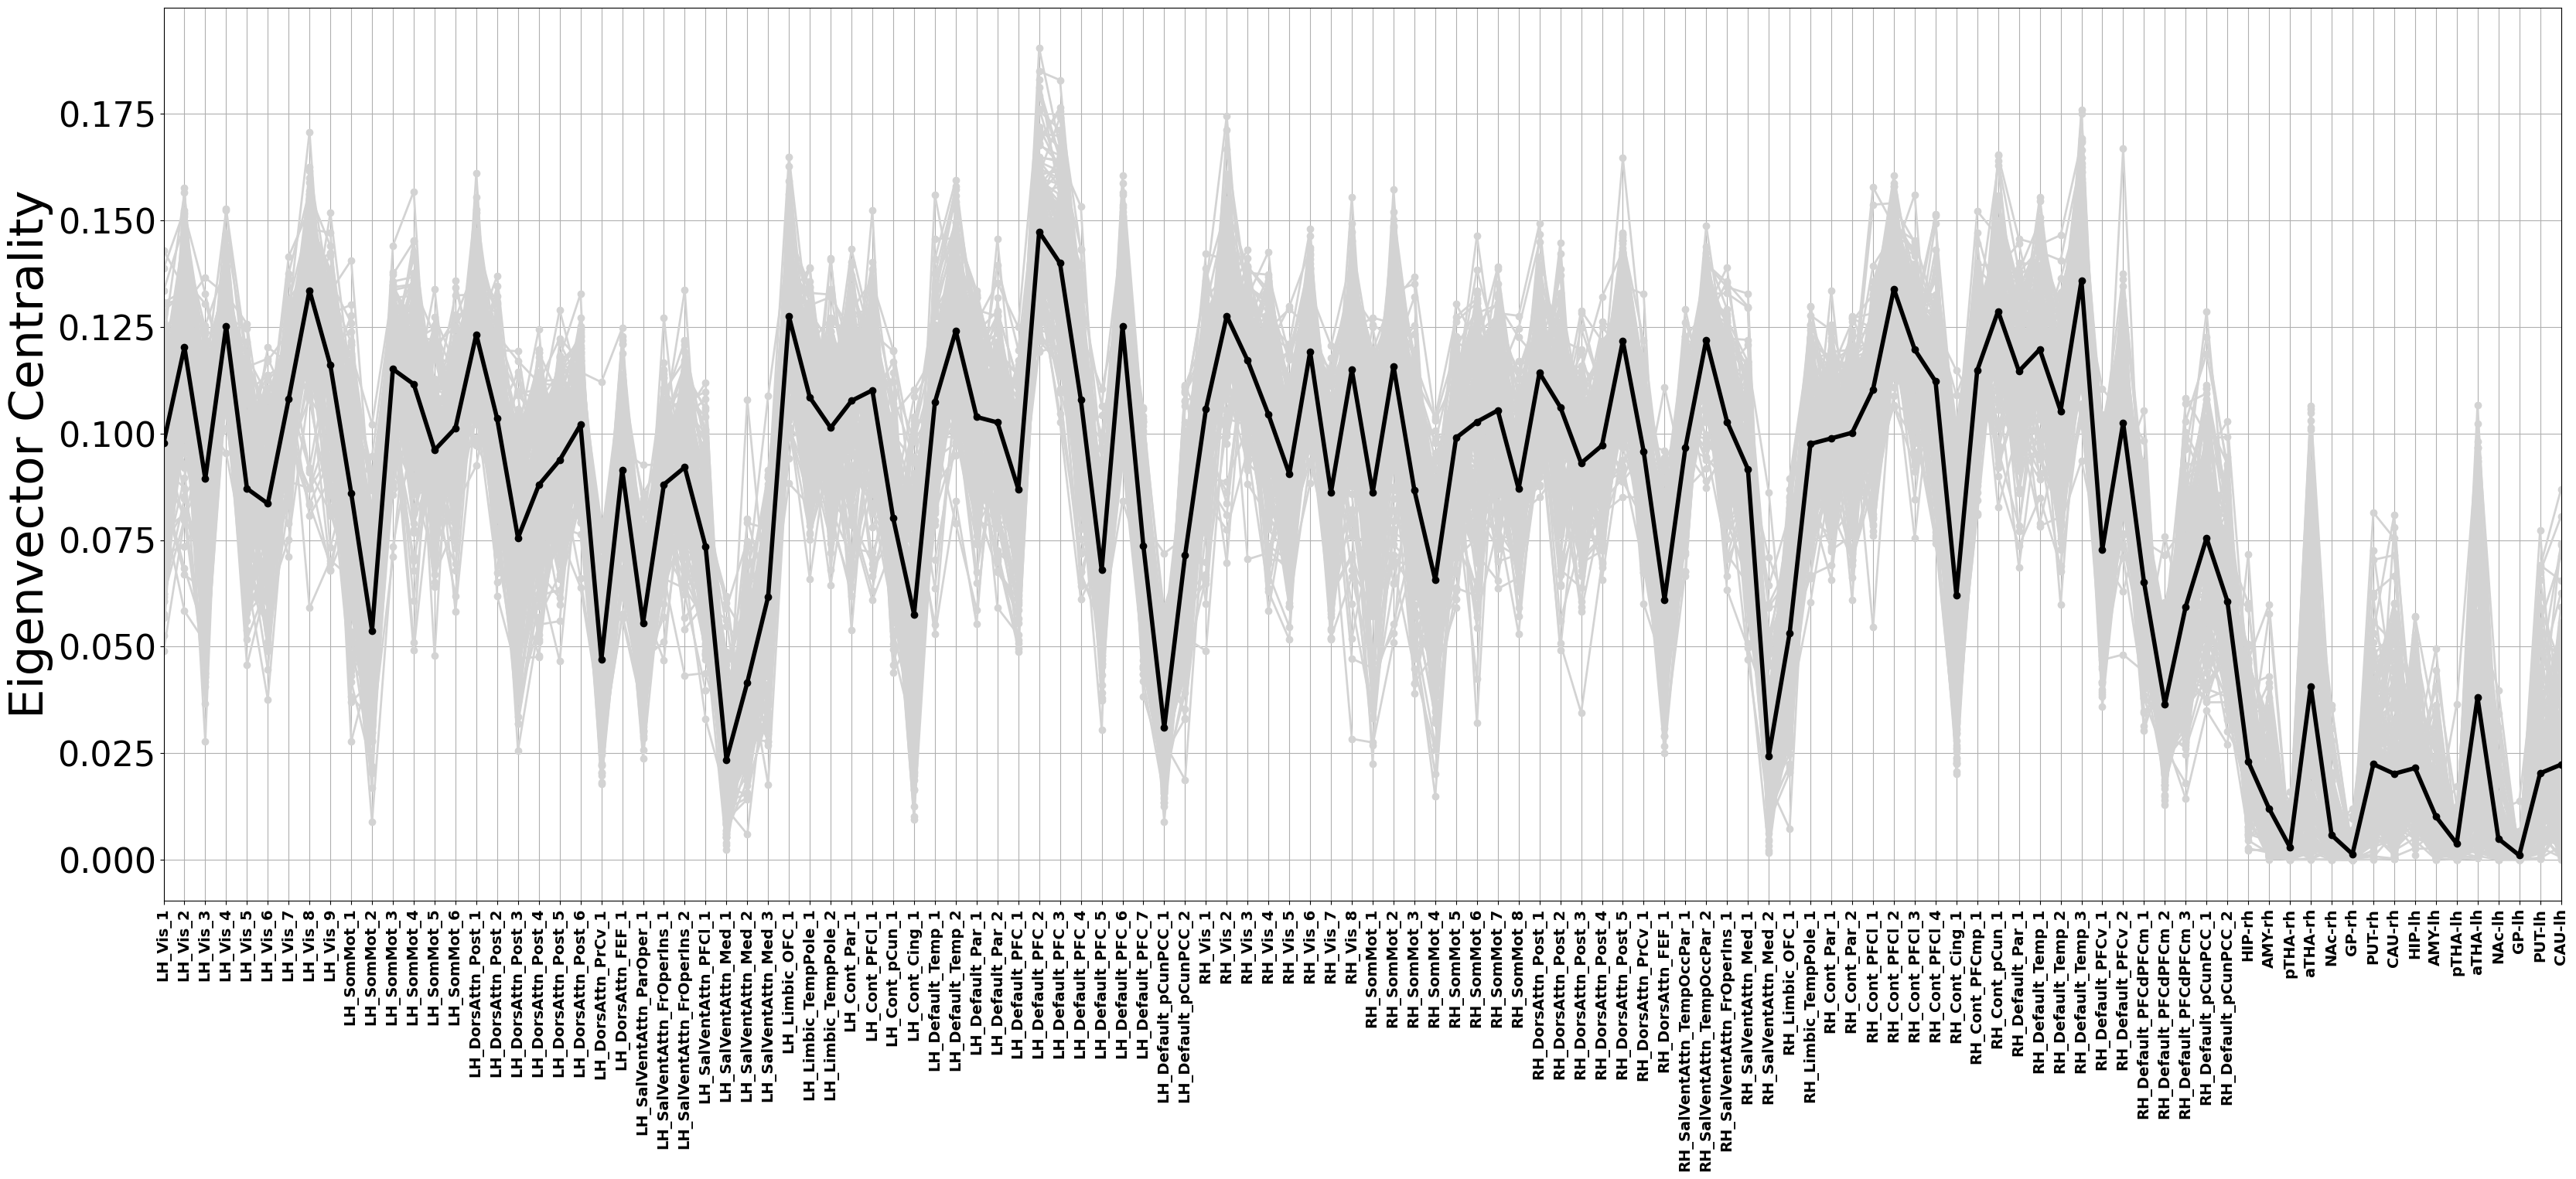

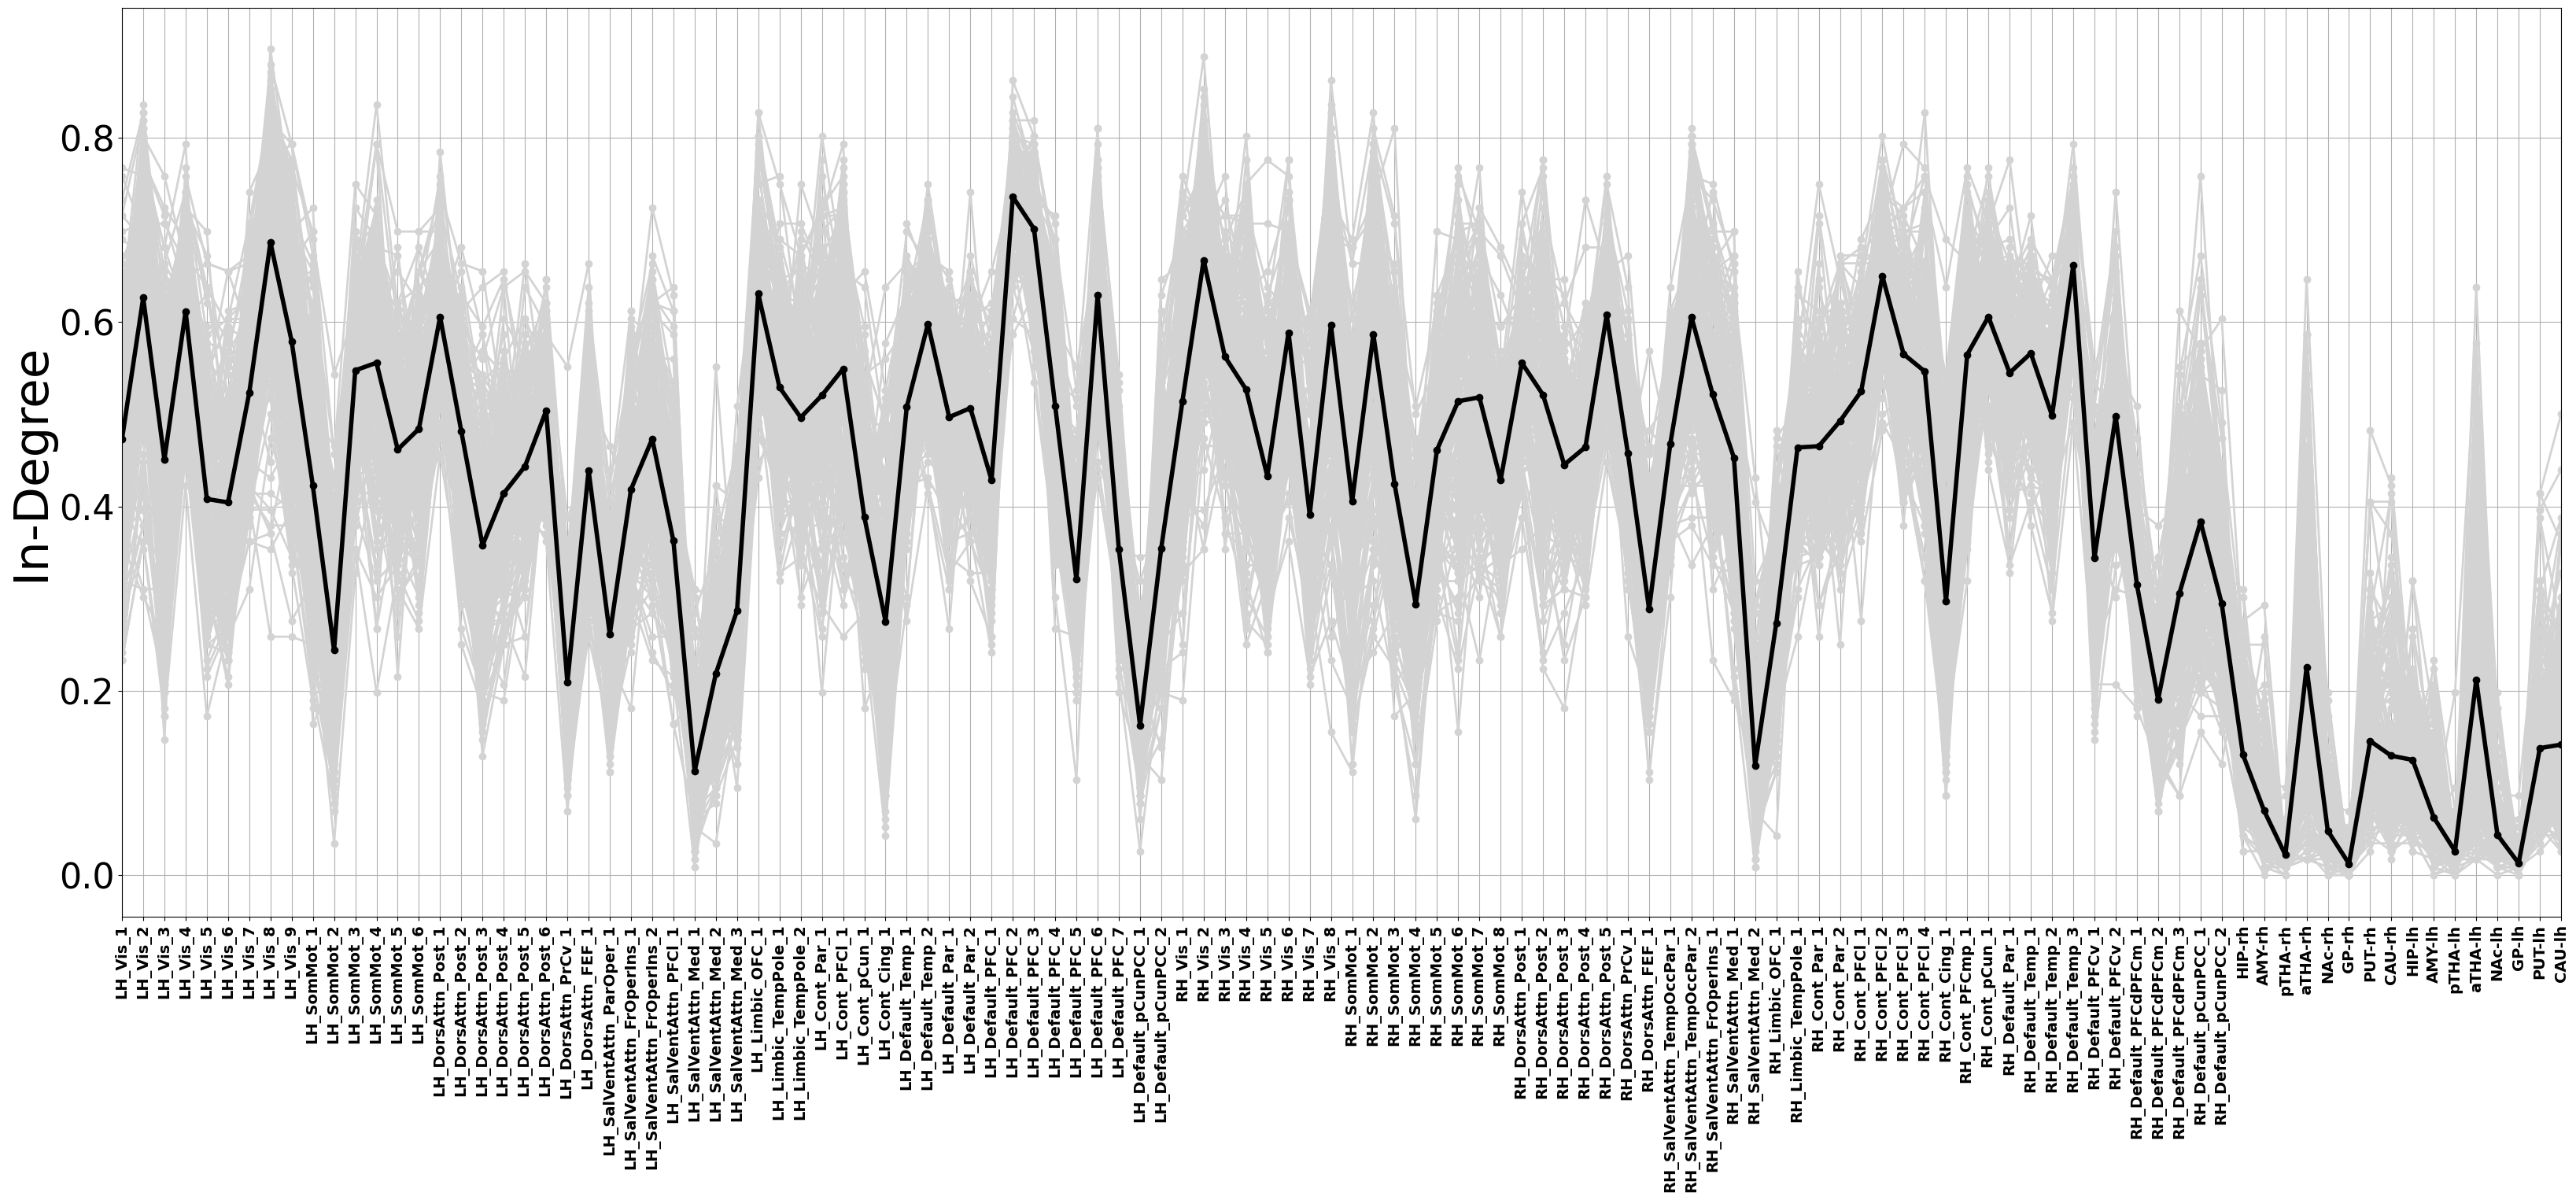

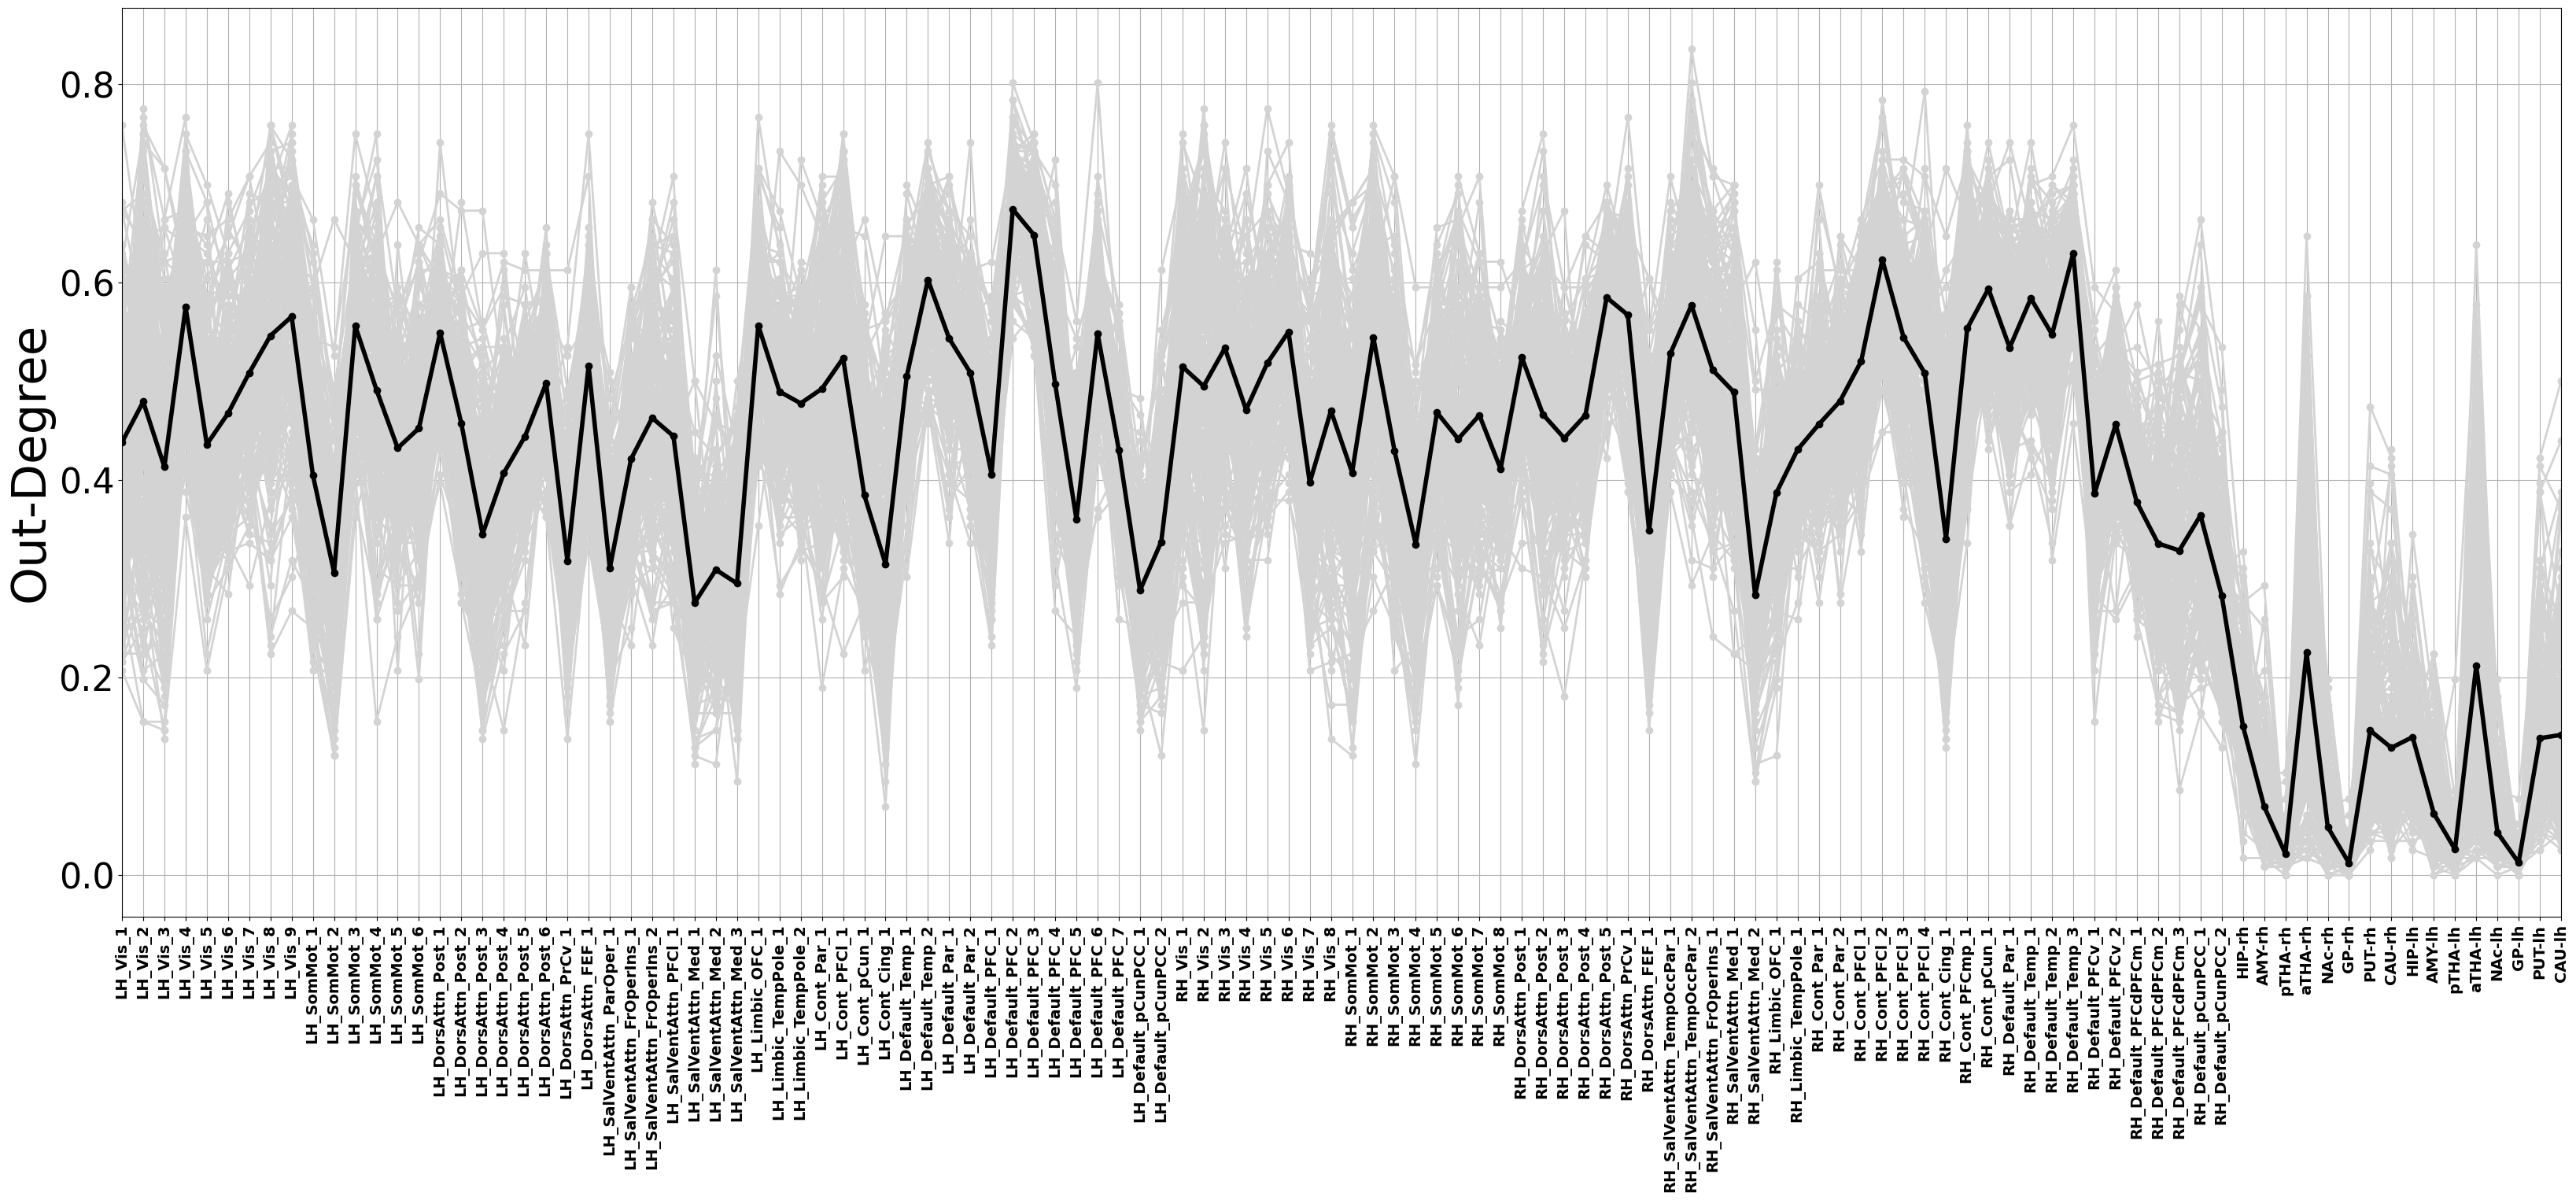

In [26]:
plt.figure(figsize = (40,15))
plt.plot(betweenness_centrality_all_parcels_individual_sub, linewidth = 2, marker = 'o', color = 'lightgray')
plt.plot(np.mean(betweenness_centrality_all_parcels_individual_sub , axis = 1), linewidth = 4, color = 'black', marker = 'o')

plt.grid()
plt.ylabel('Betweenness Centrality', fontsize = 44)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical',fontweight = 'bold')
plt.yticks(fontsize = 32 )
plt.xlim([0,num_parcels-1])
 

plt.figure(figsize = (40,15))
plt.plot(eigenvector_centrality_all_parcels_individual_sub, linewidth = 2, marker = 'o', color = 'lightgray')
plt.plot(np.mean(eigenvector_centrality_all_parcels_individual_sub , axis = 1), linewidth = 4, color = 'black', marker = 'o')

plt.grid()
plt.ylabel('Eigenvector Centrality', fontsize = 44)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical',fontweight = 'bold')
plt.yticks(fontsize = 32 )
plt.xlim([0,num_parcels-1])


plt.figure(figsize = (40,15))
plt.plot(in_degree_all_parcels_individual_sub, linewidth = 2, marker = 'o', color = 'lightgray')
plt.plot(np.mean(in_degree_all_parcels_individual_sub , axis = 1), linewidth = 4, color = 'black', marker = 'o')

plt.grid()
plt.ylabel('In-Degree', fontsize = 44)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical',fontweight = 'bold')
plt.yticks(fontsize = 32 )
plt.xlim([0,num_parcels-1])



plt.figure(figsize = (40,15))
plt.plot(out_degree_all_parcels_individual_sub, linewidth = 2, marker = 'o', color = 'lightgray')
plt.plot(np.mean(out_degree_all_parcels_individual_sub , axis = 1), linewidth = 4, color = 'black', marker = 'o')

plt.grid()
plt.ylabel('Out-Degree', fontsize = 44)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical',fontweight = 'bold')
plt.yticks(fontsize = 32 )
plt.xlim([0,num_parcels-1])



#### Nodal degree and causal flow

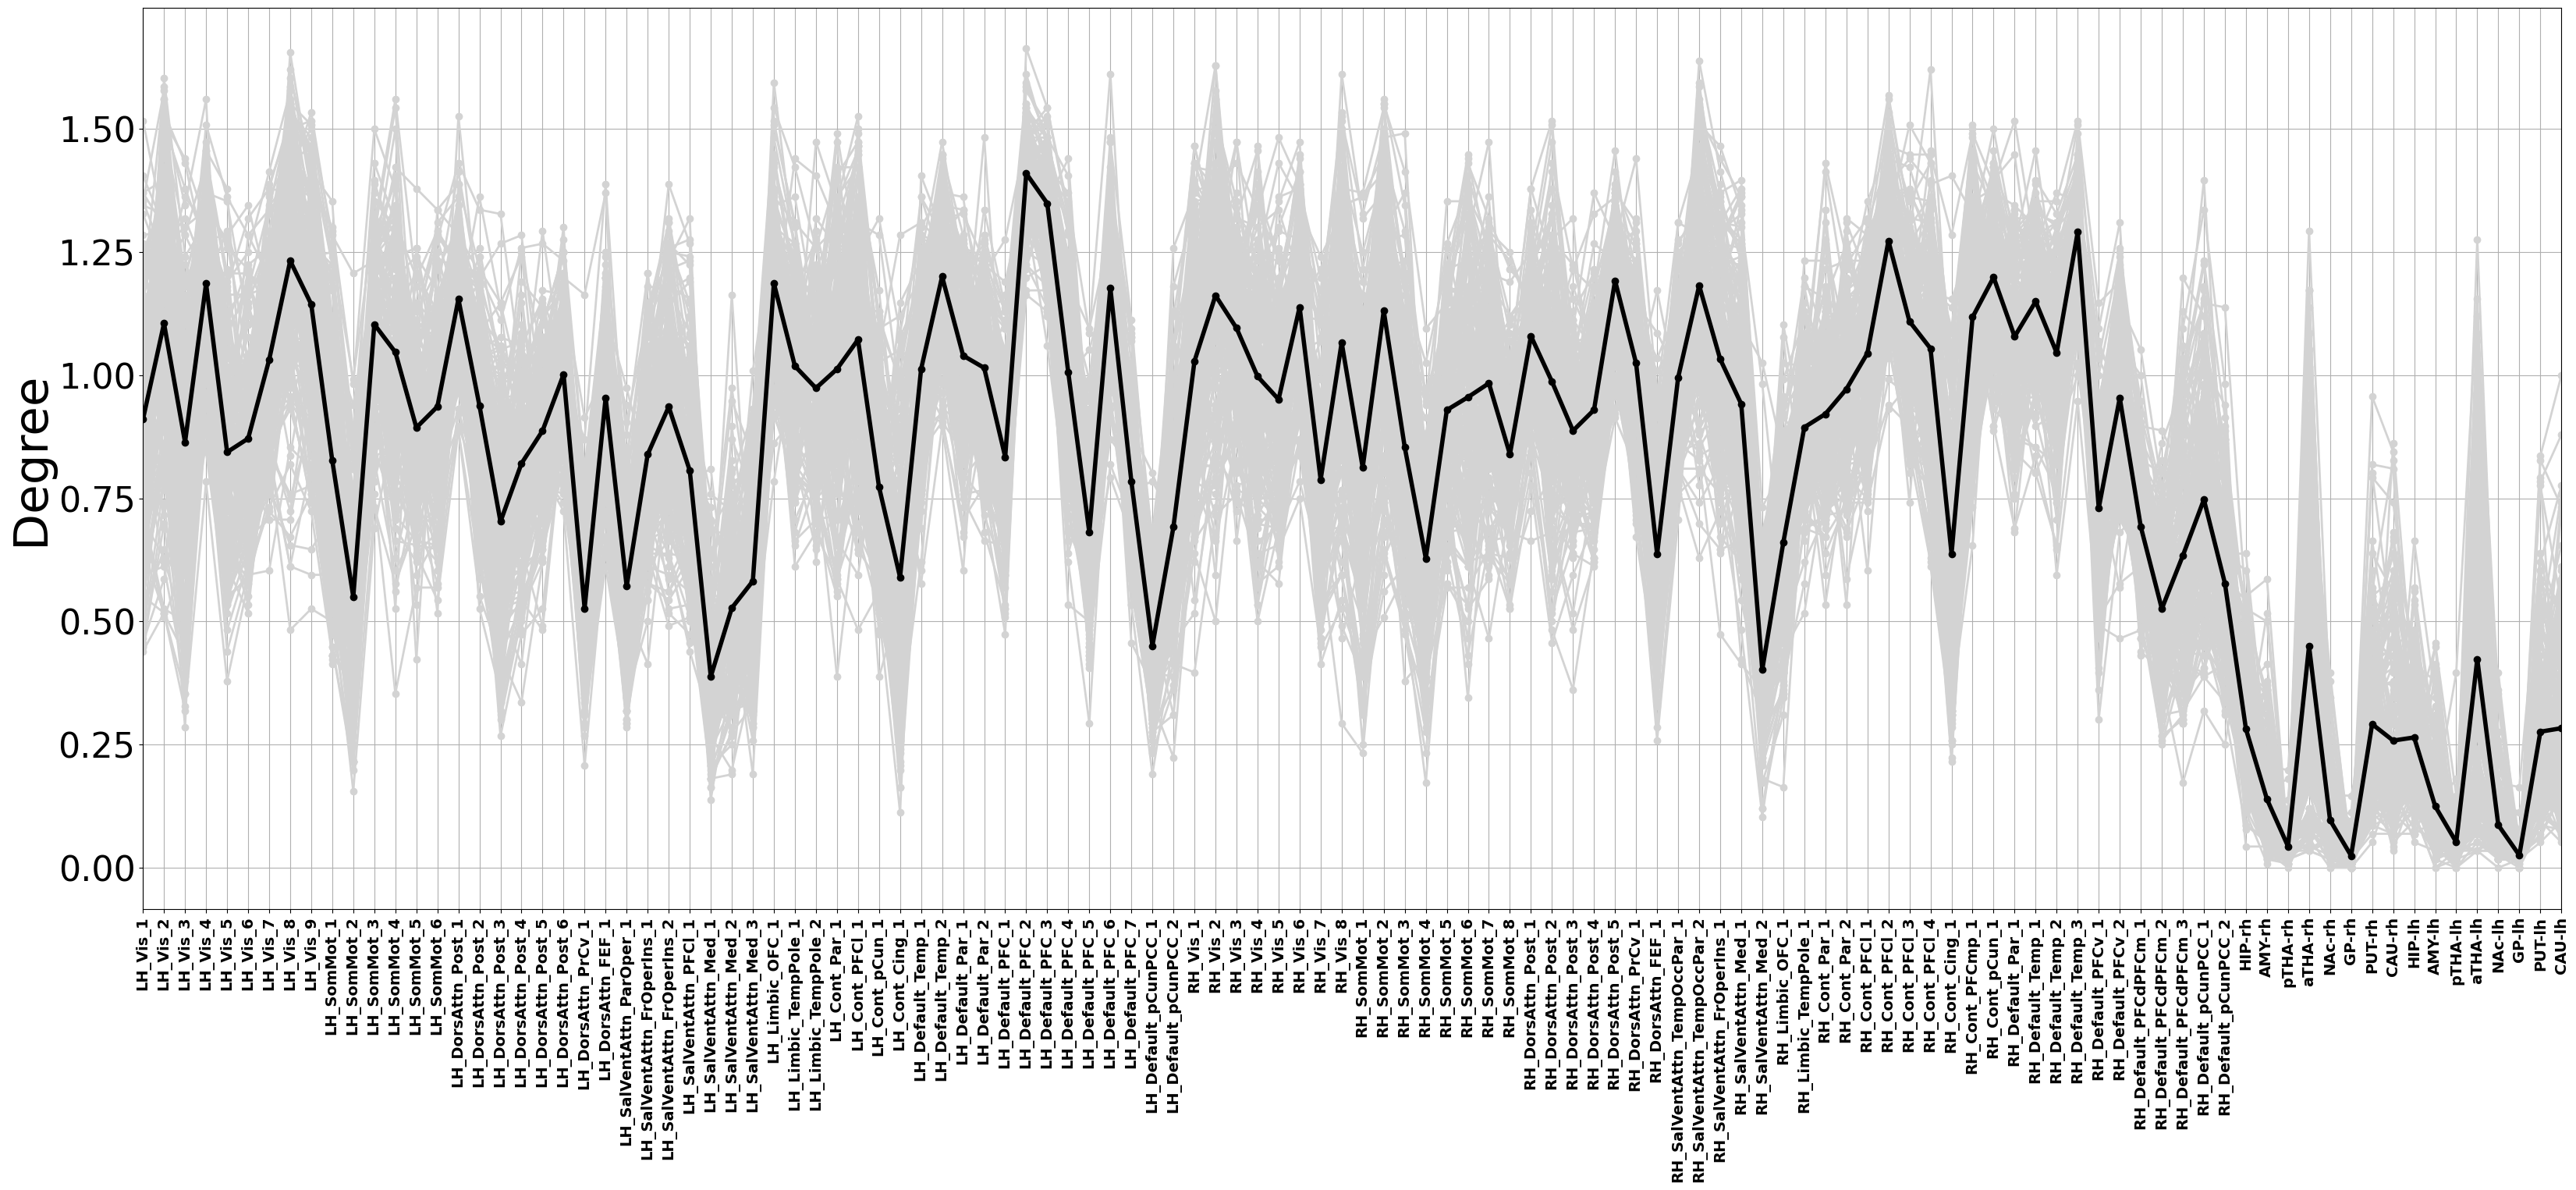

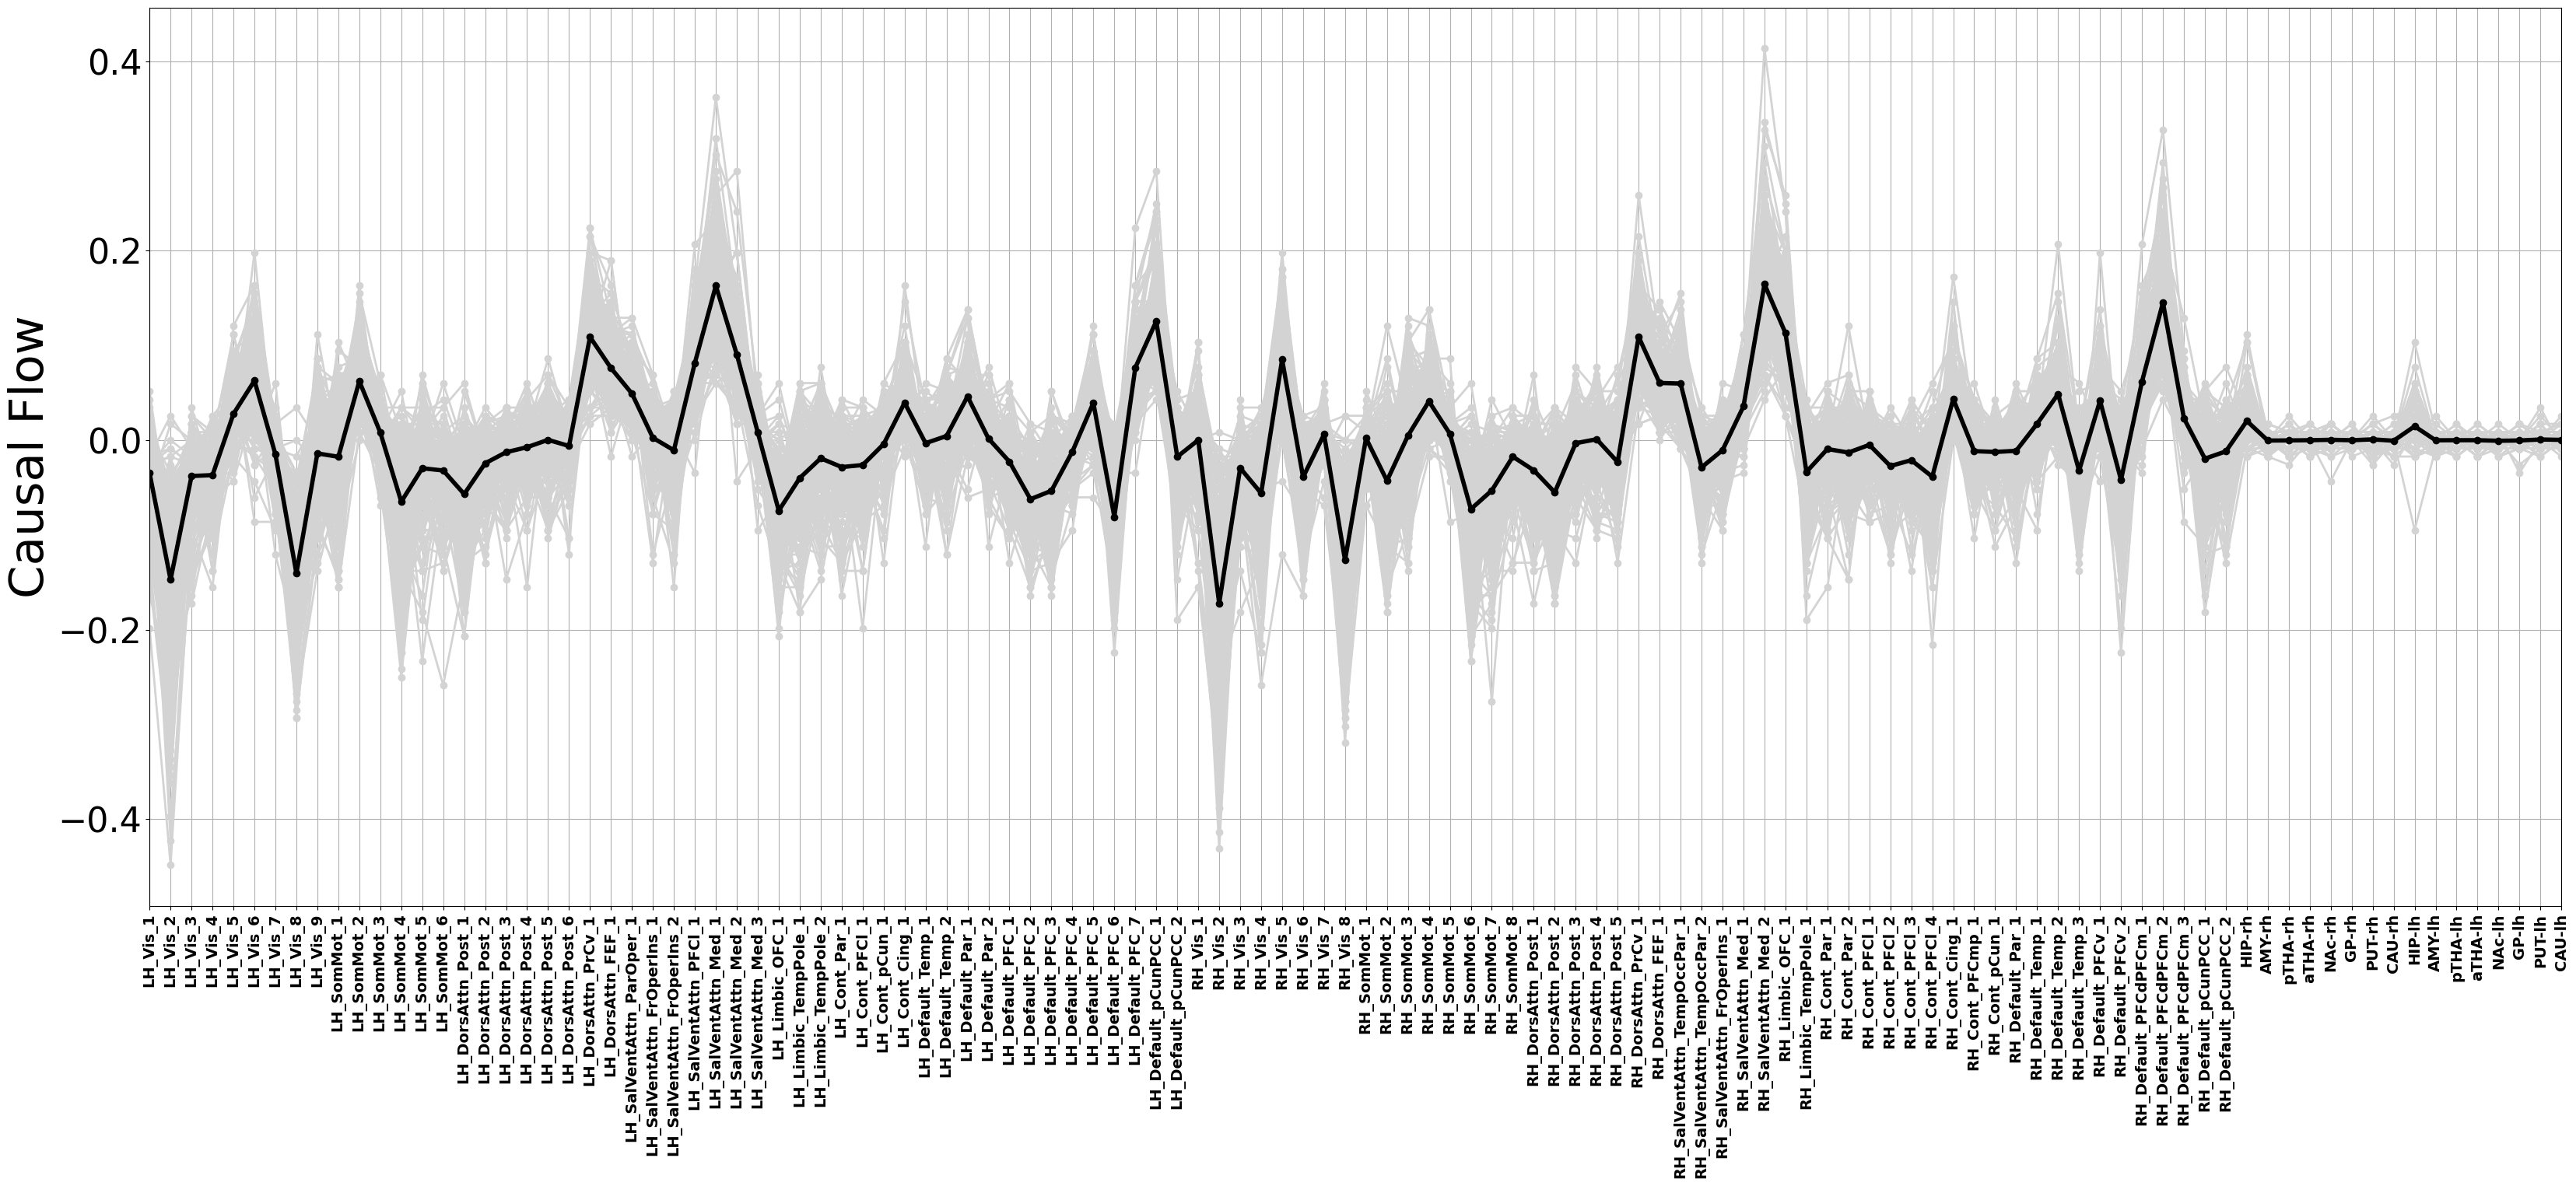

In [27]:
plt.figure(figsize = (40,15))
plt.plot(degree_all_parcels_individual_sub, linewidth = 2, marker = 'o', color = 'lightgray')
plt.plot(np.mean(degree_all_parcels_individual_sub , axis = 1), linewidth = 4, color = 'black', marker = 'o')

plt.grid()
plt.ylabel('Degree', fontsize = 44)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical',fontweight = 'bold')
plt.yticks(fontsize = 32 )
plt.xlim([0,num_parcels-1])


plt.figure(figsize = (40,15))
plt.plot(causal_flow_all_parcels_individual_sub, linewidth = 2,color = 'lightgray',  marker = 'o')
plt.plot(np.mean(causal_flow_all_parcels_individual_sub, axis = 1), linewidth = 4, color = 'black', marker = 'o')

plt.grid()
plt.ylabel('Causal Flow', fontsize = 44)
plt.xticks(np.arange(0,num_parcels), labels= parcel_labels, fontsize = 14, rotation = 'vertical', fontweight = 'bold')
p = plt.yticks(fontsize = 32)

plt.xlim([0,num_parcels-1])


#### Save Nodal Degree and Causal Flow of cotrical parcels to visualize on brain

In [28]:
# scipy.io.savemat(os.path.join(results_folder,'hcp_rest_average_cortical_causal_flow_and_degree.mat'),{'causal_flow':np.mean(causal_flow_all_parcels_individual_sub[0:num_cortical_parcels,:], axis = 1) ,'degree': np.mean(degree_all_parcels_individual_sub[0:num_cortical_parcels,:] , axis = 1)} )

### Subnetwork Graphs

#### Average subnetwork graph (averaged over subnetwork graphs of 200 subjects)

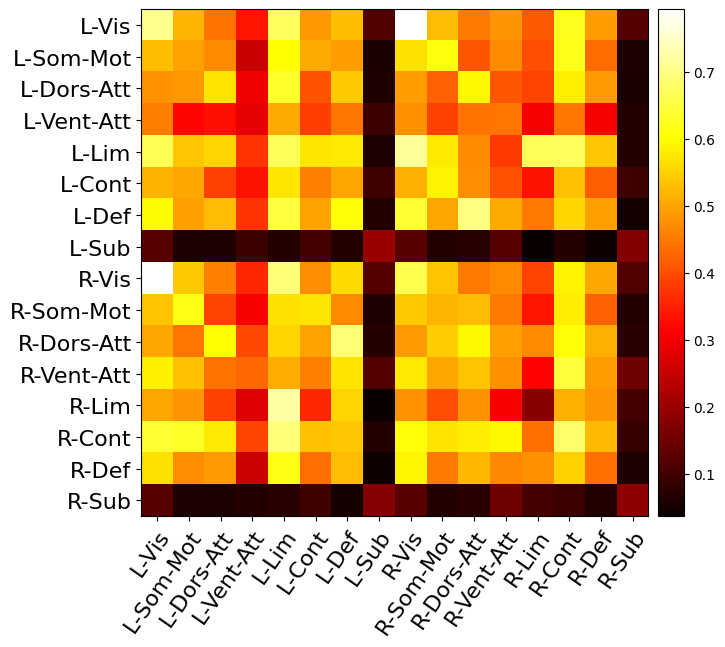

In [29]:
plt.figure(figsize = (7,7))
ax = plt.subplot()
im = plt.imshow(np.mean(all_networks_num_edges_from_to_individual_sub, axis = 2), cmap = 'hot')
ax.set_xticks(np.arange(len(net_labels_visualization)), labels = net_labels_visualization , fontsize = 16)
ax.set_yticks(np.arange(len(net_labels_visualization)), labels = net_labels_visualization , fontsize = 16)
g = plt.setp(ax.get_xticklabels(), rotation = 55, ha = "right",
         rotation_mode="anchor")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
   
plt.colorbar(im, cax=cax)

In [30]:
all_subnetwork_colors = np.array([[120,  18, 134], [70, 130, 180],[0, 118,  14],[196,  58, 250], [220, 248, 164],[230, 148,  34], [205,  62,  78],[0,0,0],[120,  18, 134], [70, 130, 180],[0, 118,  14],[196,  58, 250], [220, 248, 164],[230, 148,  34], [205,  62,  78],[0,0,0]])

In [31]:
temp = np.floor(np.mean(all_networks_num_edges_from_to_individual_sub, axis = 2)*100)/100
temp[temp<0.50] = 0

temp_caual_flow = np.mean(temp, axis = 1)- np.mean(temp, axis = 0)
all_subnetwork_colors = np.zeros((len(temp_caual_flow), 3))
for i in range(0,len(temp_caual_flow)):

    if temp_caual_flow[i]>0:
        print(temp_caual_flow[i], np.max(np.abs(temp_caual_flow)), temp_caual_flow[i]/np.max(np.abs(temp_caual_flow)))
        all_subnetwork_colors [i,0] = temp_caual_flow[i]/np.max(np.abs(temp_caual_flow))
        all_subnetwork_colors [i,1] = 0
        all_subnetwork_colors [i,2] = 0

    elif temp_caual_flow[i]<0:

        all_subnetwork_colors [i,0] = 0
        all_subnetwork_colors [i,1] = 0
        all_subnetwork_colors [i,2] = np.abs(temp_caual_flow[i])/np.max(np.abs(temp_caual_flow))
    else:

        all_subnetwork_colors [i,0] = 1
        all_subnetwork_colors [i,1] = 1
        all_subnetwork_colors [i,2] = 1

0.006874999999999992 0.20750000000000002 0.03313253012048189
0.03125 0.20750000000000002 0.1506024096385542
0.06437500000000002 0.20750000000000002 0.3102409638554217
0.03437499999999999 0.20750000000000002 0.16566265060240956
0.20750000000000002 0.20750000000000002 1.0
0.07 0.20750000000000002 0.3373493975903614
0.07875000000000001 0.20750000000000002 0.3795180722891567


#### Nodal degree and Causal flow

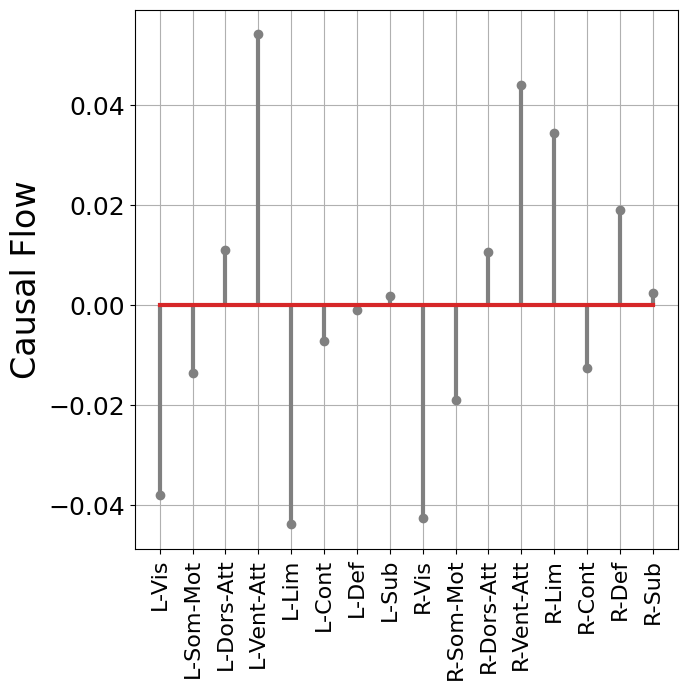

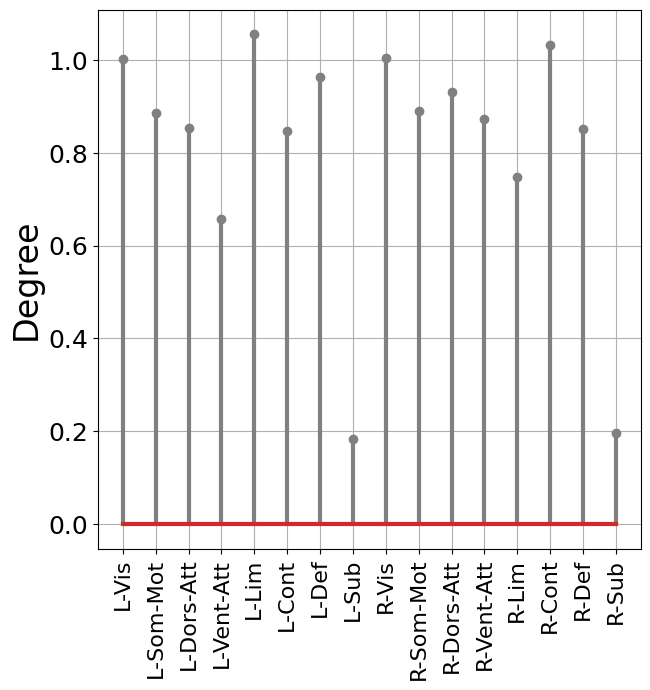

In [37]:
causal_flow_from_average_of_networks = np.mean(np.mean(all_networks_num_edges_from_to_individual_sub, axis = 2), axis = 1) - np.mean(np.mean(all_networks_num_edges_from_to_individual_sub, axis = 2), axis = 0)

plt.figure(figsize = (7,7))
p = plt.stem(causal_flow_from_average_of_networks, linefmt = 'gray')
plt.setp(p,'linewidth', 3)

plt.xticks(np.arange(0,num_networks), labels = net_labels_visualization, rotation = 90, fontsize = 16)
plt.ylabel('Causal Flow', fontsize = 24)
plt.yticks(fontsize = 18)
plt.grid()

degree_from_average_of_networks = np.mean(np.mean(all_networks_num_edges_from_to_individual_sub, axis = 2), axis = 1) + np.mean(np.mean(all_networks_num_edges_from_to_individual_sub, axis = 2), axis = 0)

plt.figure(figsize = (7,7))
p = plt.stem(degree_from_average_of_networks, linefmt = 'gray')
plt.setp(p,'linewidth', 3)

plt.xticks(np.arange(0,num_networks), labels = net_labels_visualization, rotation = 90, fontsize = 16)
plt.ylabel('Degree', fontsize = 24)
plt.yticks(fontsize = 18)
plt.grid()

#### Degree and causal flow of the subnetwork graphs of all the subjects

In [38]:
subnet_graph_degree_all = []
subnet_graph_causal_flow_all = []

for s in range(0, num_subjects_ready):
    subnet_graph = all_networks_num_edges_from_to_individual_sub[:,:,s]
    subnet_graph_degree = np.mean(subnet_graph, axis = 1) + np.mean(subnet_graph, axis = 0)
    subnet_graph_causal_flow = np.mean(subnet_graph, axis = 1) - np.mean(subnet_graph, axis = 0)
    subnet_graph_degree_all.append(subnet_graph_degree)
    subnet_graph_causal_flow_all.append(subnet_graph_causal_flow)

/tmp/ipykernel_3706071/3671333381.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[:,i], y[:,i], c = standard_colors[i,:], s = 2, label = net_labels_visualization[i][2:],  marker = markers[i])
/tmp/ipykernel_3706071/3671333381.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[:, i+8], y[:,i+8], c = standard_colors[i,:], s = 2,  marker = markers[i])


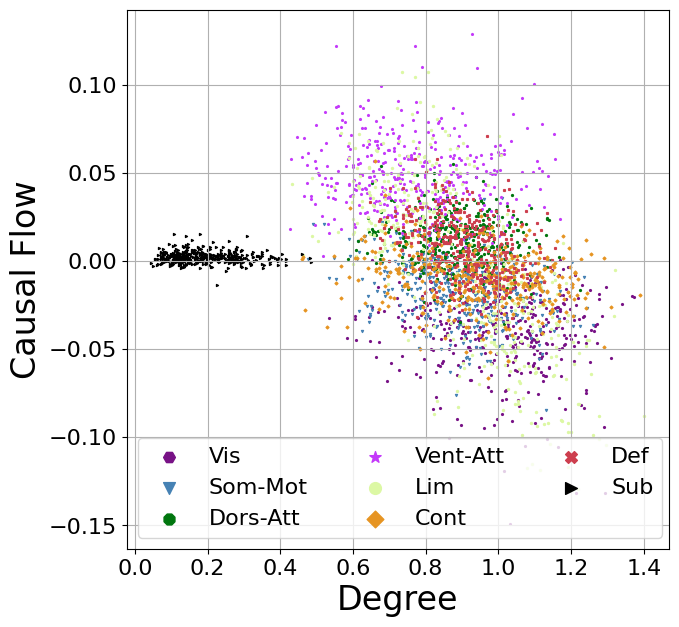

In [39]:
plt.figure(figsize = (7,7))

x = np.array(subnet_graph_degree_all)
y = np.array(subnet_graph_causal_flow_all)

markers = ['H', 'v','8', '*', 'o', 'D','X','>']


standard_colors = np.concatenate((Yeo2011_7Networks_ColorLUT/255, np.array([[0, 0, 0]])), axis = 0)

for i in range(0, int(num_networks/2)):

    plt.scatter(x[:,i], y[:,i], c = standard_colors[i,:], s = 2, label = net_labels_visualization[i][2:],  marker = markers[i])
    plt.scatter(x[:, i+8], y[:,i+8], c = standard_colors[i,:], s = 2,  marker = markers[i])

plt.grid()
plt.xlabel('Degree', fontsize = 24)
plt.ylabel('Causal Flow', fontsize = 24)
plt.xticks(fontsize = 16 )
plt.yticks(fontsize = 16 )

plt.legend(fontsize = 16, ncol = 3, loc = 'lower left', markerscale = 6)

xmin, xmax, ymin, ymax = plt.axis()


/tmp/ipykernel_3706071/101920076.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[:,i], y[:,i], c = standard_colors[i,:], s = 2, marker = markers[i])
/tmp/ipykernel_3706071/101920076.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[:, i+8], y[:,i+8], c = standard_colors[i,:], s = 2, marker = markers[i])


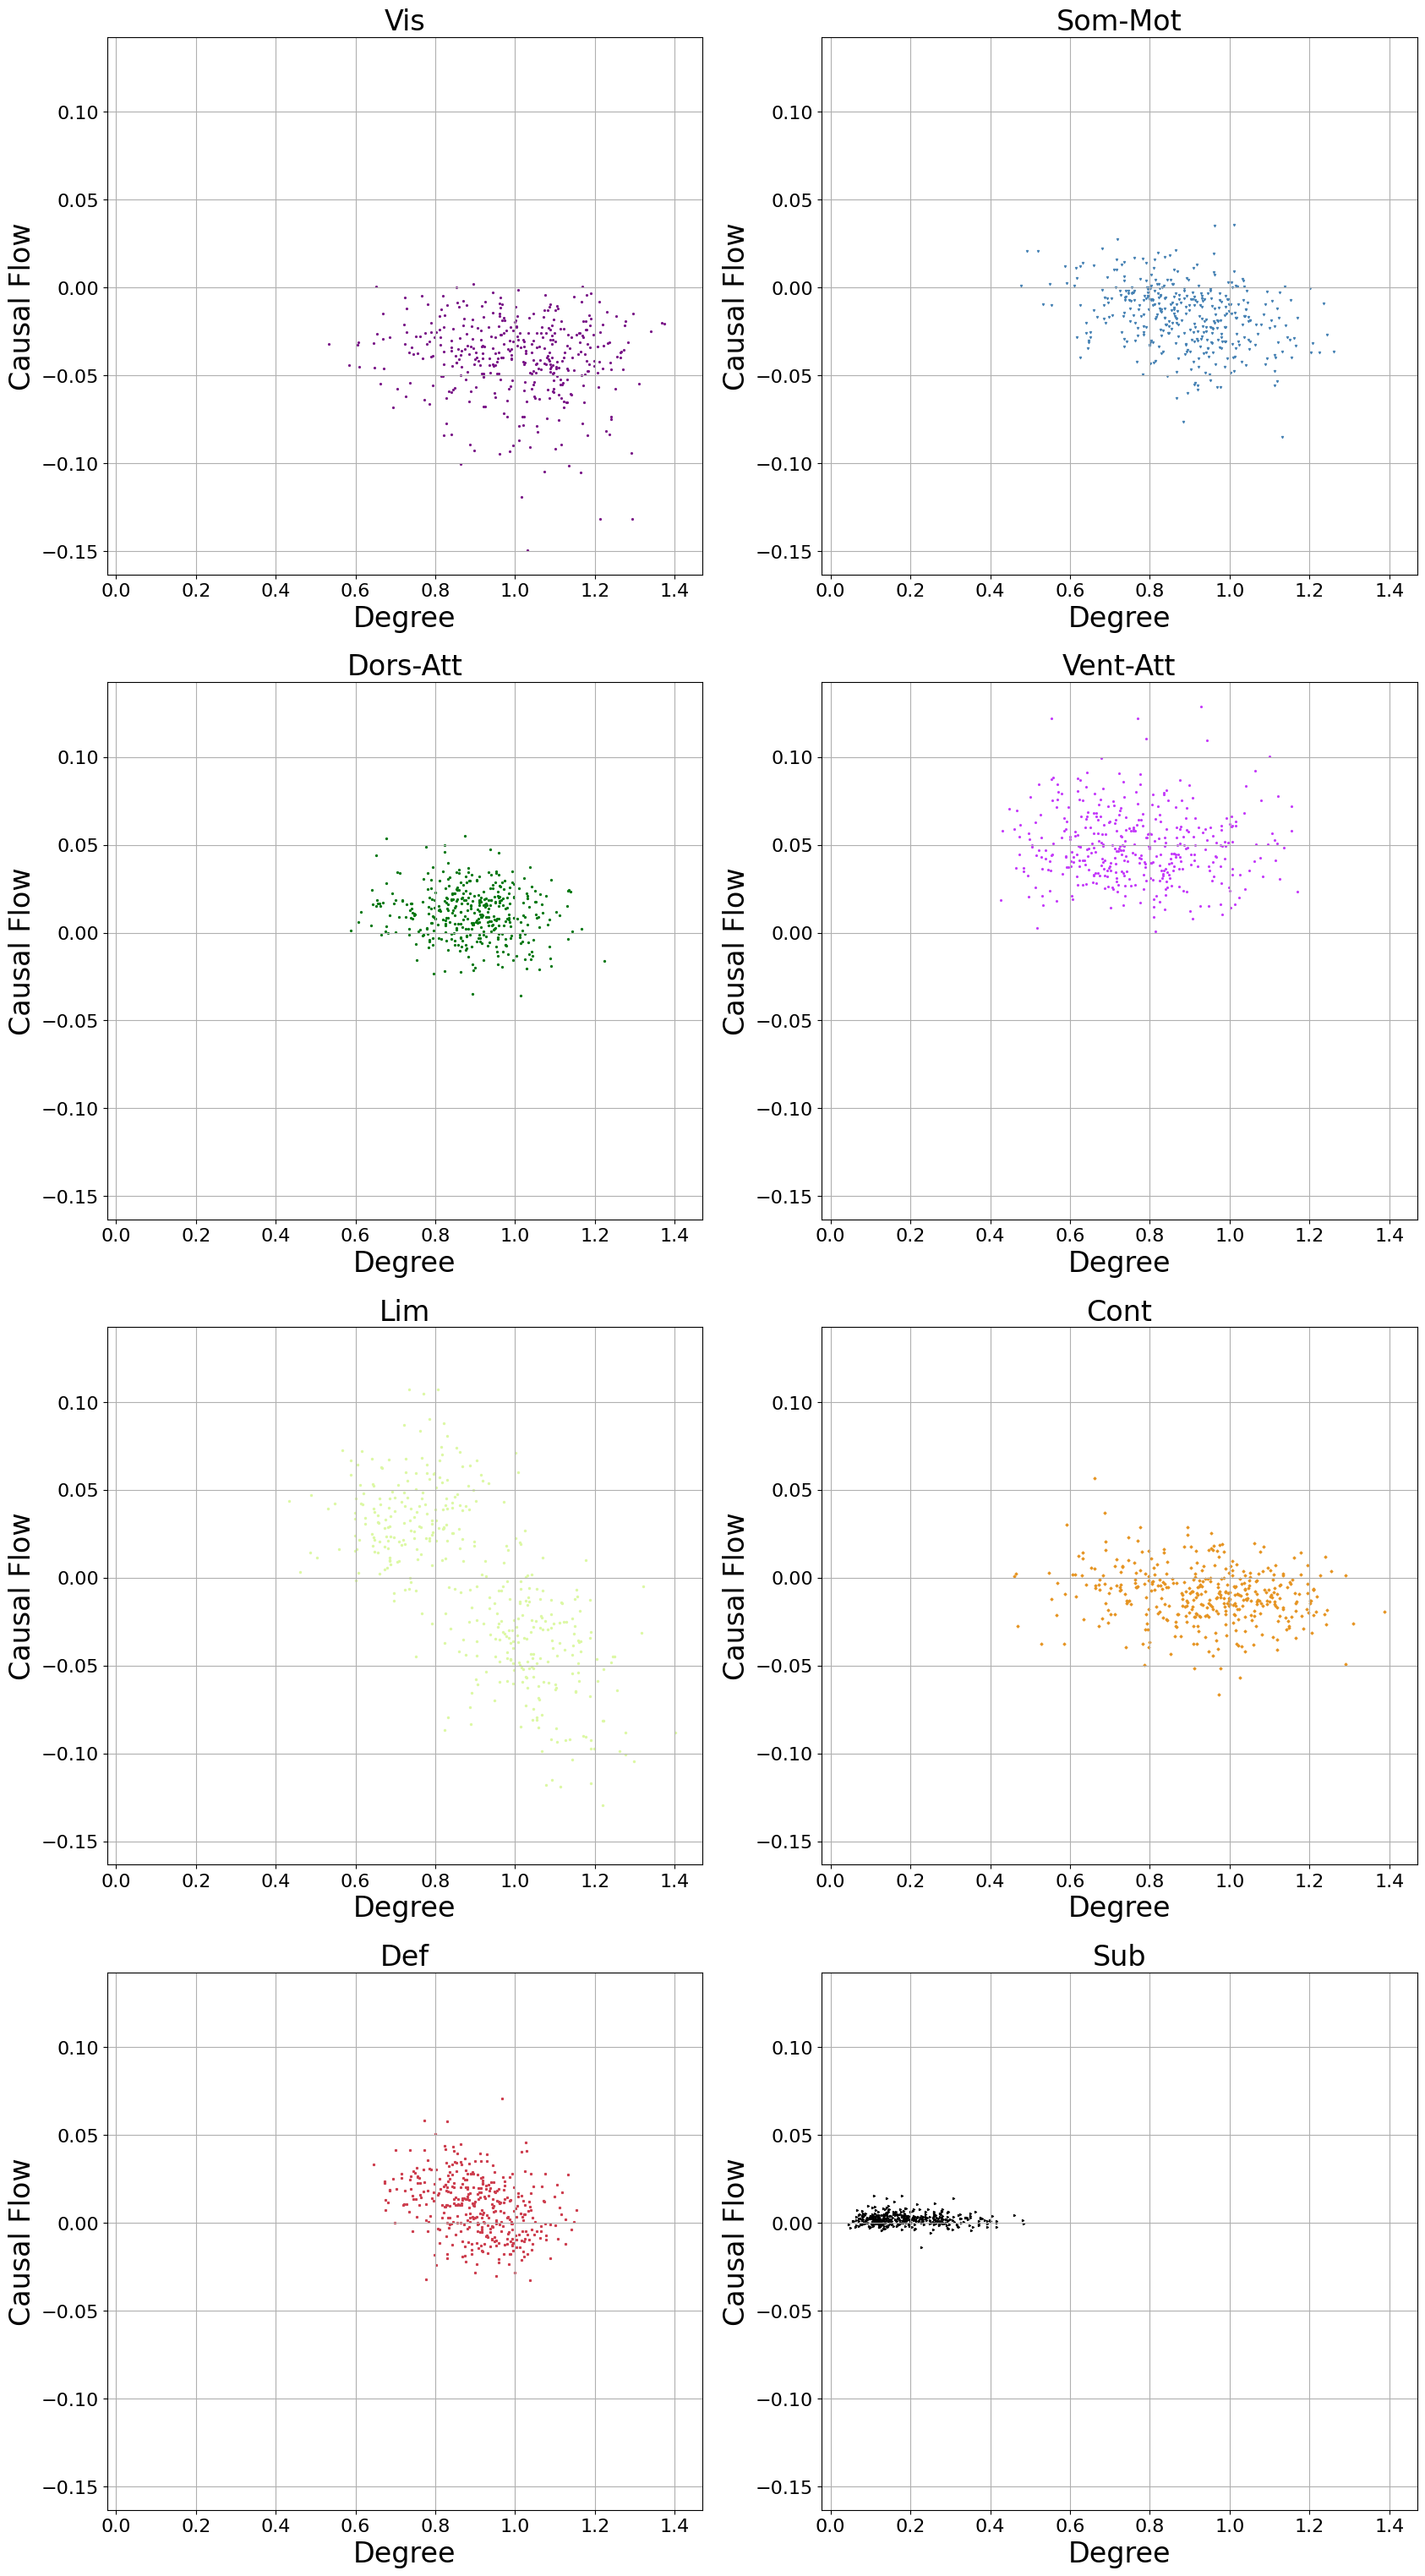

In [40]:
plt.figure(figsize = (20, 38))
x = np.array(subnet_graph_degree_all)
y = np.array(subnet_graph_causal_flow_all)
markers = ['H', 'v','8', '*', 'o', 'D','X','>']

standard_colors = np.concatenate((Yeo2011_7Networks_ColorLUT/255, np.array([[0, 0, 0]])), axis = 0)

for i in range(0, int(num_networks/2)):

    plt.subplot(4,2,i+1)
    plt.scatter(x[:,i], y[:,i], c = standard_colors[i,:], s = 2, marker = markers[i])
    plt.scatter(x[:, i+8], y[:,i+8], c = standard_colors[i,:], s = 2, marker = markers[i])

    plt.grid(visible = True)
    plt.xlabel('Degree', fontsize = 24)
    plt.ylabel('Causal Flow', fontsize = 24)
    plt.xticks(fontsize = 16 )
    plt.yticks(fontsize = 16 )
    plt.title(net_labels_visualization[i][2:], fontsize = 24)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin,ymax)

### Average graph (binary graph and graph parameters)

Density of the average graph after thresholding: 0.4118634809750297


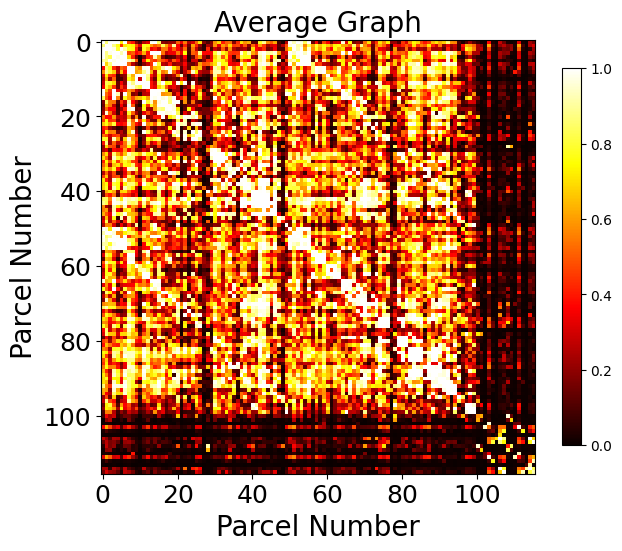

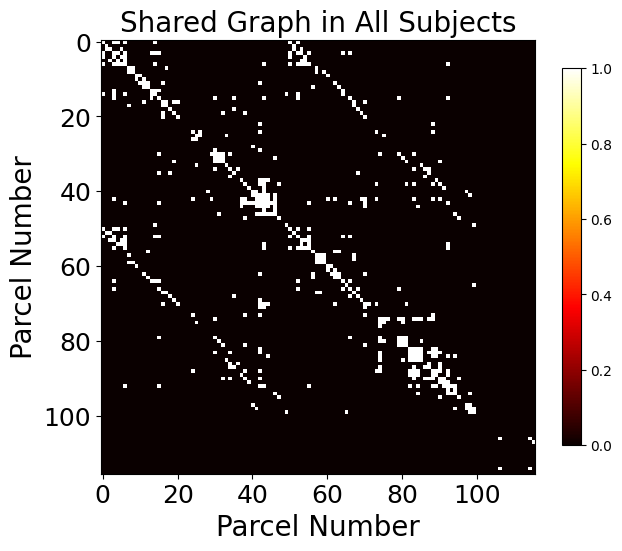

In [41]:
avg_graph = np.mean(np.array(hcp_rest_all_graphs), axis = 0)

plt.figure(figsize = (7,7))
plt.imshow(avg_graph, cmap = 'hot')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.colorbar(location = 'right', shrink = 0.7)
plt.xlabel('Parcel Number', fontsize = 20)
plt.ylabel('Parcel Number', fontsize = 20)
plt.title('Average Graph', fontsize = 20)


plt.figure(figsize = (7,7))
threshold = 1
avg_graph_binarized = np.zeros_like(avg_graph) 
avg_graph_binarized[avg_graph <  threshold] = 0
avg_graph_binarized[avg_graph >= threshold] = 1
plt.imshow(avg_graph_binarized, cmap = 'hot')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.colorbar(location = 'right', shrink = 0.7)
plt.xlabel('Parcel Number', fontsize = 20)
plt.ylabel('Parcel Number', fontsize = 20)
plt.title('Shared Graph in All Subjects', fontsize = 20)

print('Density of the average graph after thresholding:', np.mean(avg_graph))

### Distribution of weights in average causal parcel-level graph vs weights of average random binary graphs

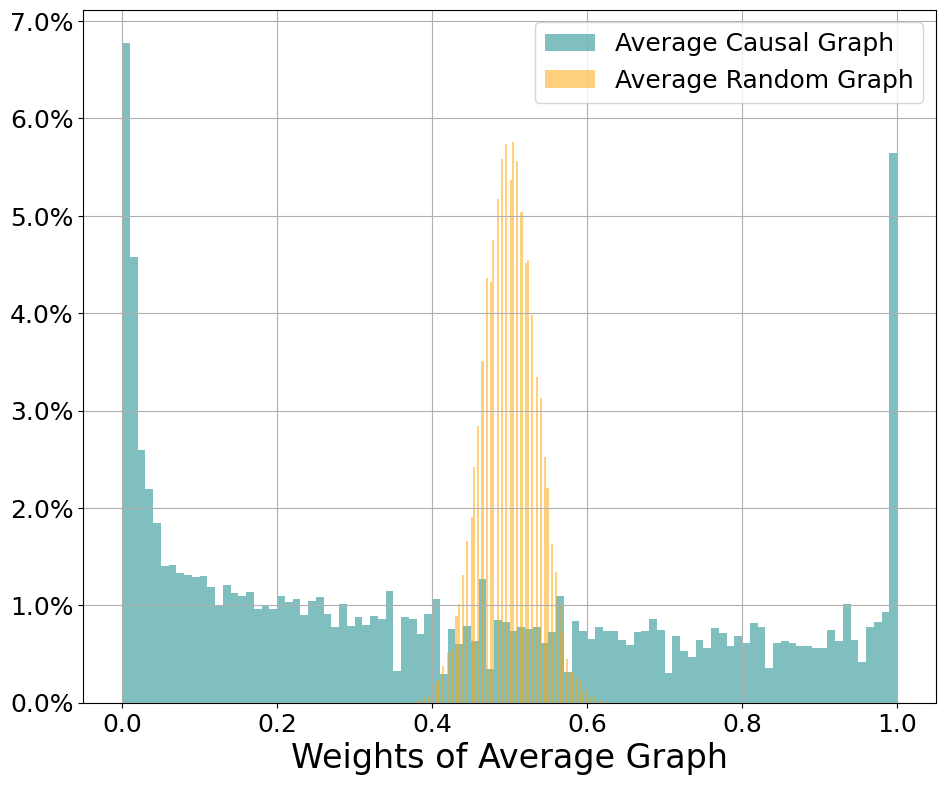

In [29]:
random_binary_matrices = np.random.randint(2, size=(num_subjects_ready, num_parcels, num_parcels))
random_binary_matrices_average = np.mean(random_binary_matrices, axis = 0)

plt.figure(figsize = (11,9))

plt.hist(avg_graph.flatten(), 100, alpha=0.5, label='Average Causal Graph', weights = np.ones(len(avg_graph.flatten()))/len(avg_graph.flatten()), color= 'Teal')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.hist(random_binary_matrices_average.flatten(), 100, alpha = 0.5, label='Average Random Graph', weights = np.ones(len(random_binary_matrices_average.flatten()))/len(random_binary_matrices_average.flatten()), color ='orange')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend(loc='upper right', fontsize = 18)

plt.xlabel('Weights of Average Graph', fontsize = 24)
h = plt.yticks(fontsize = 18)
h = plt.xticks(fontsize = 18)

plt.grid(visible = True)


### Visualize Causal Flow on the brain

/home/fahimeh/.local/lib/python3.10/site-packages/nilearn/plotting/displays/_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


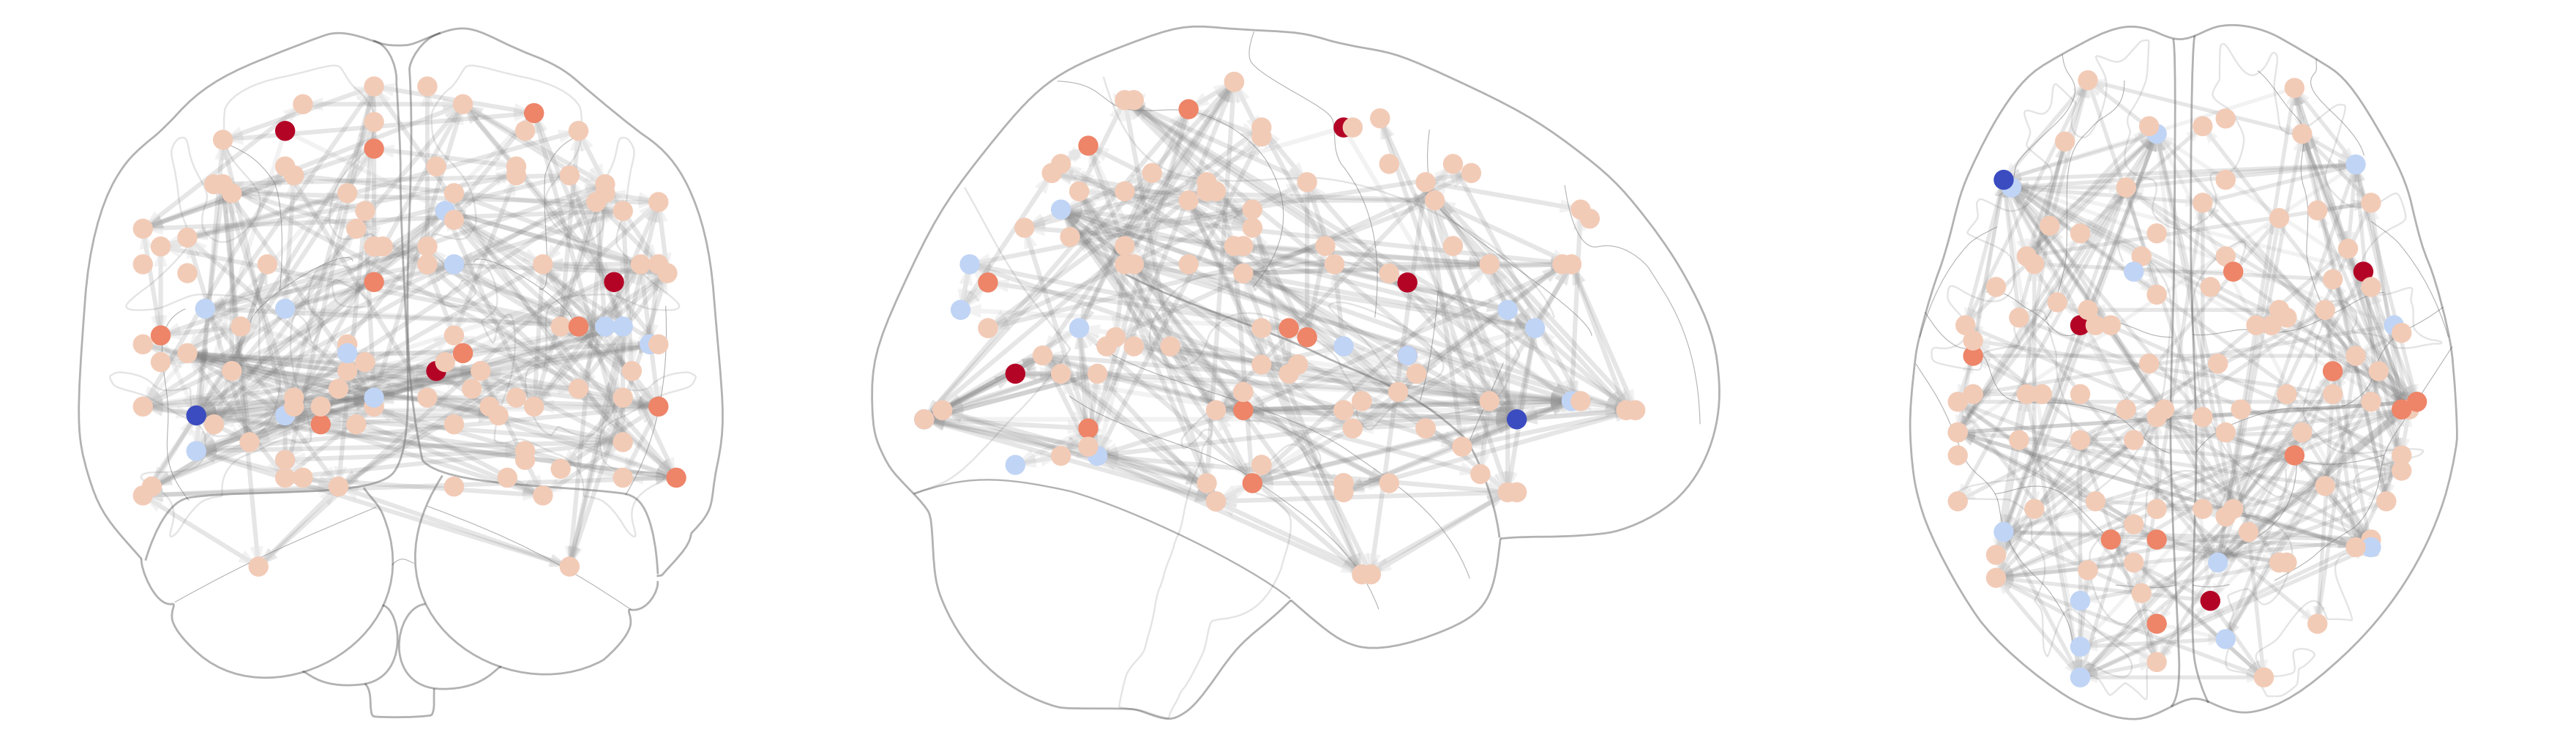

In [30]:
np.fill_diagonal(avg_graph_binarized, 0)
avg_graph_binarized_causal_flow = np.mean(avg_graph_binarized, axis = 1) -  np.mean(avg_graph_binarized, axis = 0)

colormap = 'coolwarm'
cmap = plt.get_cmap(colormap)
norm = colors.Normalize(vmin=np.min(avg_graph_binarized_causal_flow), vmax=np.max(avg_graph_binarized_causal_flow))
node_colors = [cmap(norm(d)) for d in avg_graph_binarized_causal_flow]

fig = plt.figure(figsize = (35,10))
brain = plotting.plot_connectome(avg_graph_binarized,
                                 node_color = node_colors,
                                 node_coords = parcel_locs,
                                 figure = fig,
                                 edge_threshold = 1,
                                 edge_kwargs={"linewidth": 0.01, "color": "gray", "alpha": 0.1},
                                 edge_vmin = 1,
                                 edge_vmax = 100000,
                                 node_size = 350,
                                 alpha = 0.3,
                                 colorbar = False,
                                 annotate= False)

node_cmap = cm.ScalarMappable(cmap = colormap)
node_cmap.set_array(avg_graph_binarized_causal_flow)
